In [216]:
import cudf as cd

import cupy 

import pandas as pd

import lightgbm as lgb

import catboost as cb

import optuna

from optuna.samplers import TPESampler

from cuml.model_selection import train_test_split

from sklearn.model_selection import KFold, StratifiedKFold

from cuml.ensemble import RandomForestClassifier

from cuml.metrics import roc_auc_score, accuracy_score

import matplotlib.pyplot as plt

import numpy as np

from cuml.datasets import make_classification

from cuml.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from cuml.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import seaborn as sns



#import lightgbm as lgb

#from catboost import CatBoostClassifier

In [87]:
train = cd.read_csv('train.csv', index_col=False)

train.drop(columns='id', inplace=True)

train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [88]:
original= cd.read_csv('credit_risk_dataset.csv', index_col=False)

original.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Exploratory Data Analysis

In [89]:
def draw_fonk(df, feature, target='loan_status'):

    crosstab = cd.crosstab(df[feature], df[target])

    

    crosstab_pandas = crosstab.to_pandas()

    

    crosstab_pandas.plot(kind='bar', stacked=True, figsize=(12, 6), cmap='coolwarm')

    plt.title(f'Stacked Bar Plot of {feature} vs {target}')

    plt.xlabel(feature)

    plt.ylabel('Counts')

    plt.xticks(rotation=45)

    plt.show()


In [90]:
df = cd.concat([train, original], ignore_index=True)

df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [91]:
ages_df = df.groupby(['person_age', 'loan_status']).size().reset_index(name='counts')

ages_df['sapareted_age'] =ages_df['person_age']//5

ages_df['loan_status1_count']=[0] * len(ages_df)

ages_df['loan_status0_count']=[0] * len(ages_df)



for k, row in enumerate(ages_df['sapareted_age'].unique().values_host):

    for i in range(len(ages_df)):

        if row == (ages_df['person_age'][i] // 5):

            if ages_df['loan_status'][i] == 1:

                ages_df.loc[k, 'loan_status1_count'] += ages_df['counts'][i]

            elif ages_df['loan_status'][i] == 0:

                ages_df.loc[k, 'loan_status0_count'] += ages_df['counts'][i]

    

ages_df

,person_age,loan_status,counts,sapareted_age,loan_status1_count,loan_status0_count
0,27,0,5614,5,5198,26363
1,80,0,1,16,2,4
2,49,1,24,9,176,852
3,55,0,40,11,39,164
4,144,0,3,28,0,3
...,...,...,...,...,...,...
103,76,1,1,15,0,0
104,48,1,40,9,0,0
105,42,1,104,8,0,0
106,123,0,3,24,0,0


In [92]:
ages_df = ages_df[(ages_df['loan_status1_count']!=0) | (ages_df['loan_status0_count']!=0)]

ages_df.sort_values(by='sapareted_age')

,person_age,loan_status,counts,sapareted_age,loan_status1_count,loan_status0_count
12,23,0,9715,4,5,18
0,27,0,5614,5,5198,26363
9,33,1,359,6,26,73
14,30,0,3096,6,0,1
7,36,1,298,7,464,2252
8,41,0,566,8,2075,11074
15,43,0,420,8,0,3
2,49,1,24,9,176,852
10,46,0,233,9,6265,29029
5,51,0,85,10,111,399


In [93]:
ages_df['loan_ratio'] = ages_df['loan_status1_count'] / ages_df['loan_status0_count']

ages_df.sort_values(by='loan_ratio')

,person_age,loan_status,counts,sapareted_age,loan_status1_count,loan_status0_count,loan_ratio
4,144,0,3,28,0,3,0.000000
14,30,0,3096,6,0,1,0.000000
15,43,0,420,8,0,3,0.000000
8,41,0,566,8,2075,11074,0.187376
0,27,0,5614,5,5198,26363,0.197170
6,58,1,13,11,1087,5486,0.198141
11,61,1,6,12,9,45,0.200000
7,36,1,298,7,464,2252,0.206039
2,49,1,24,9,176,852,0.206573
10,46,0,233,9,6265,29029,0.215819


All these processes were just to see the following graph:)

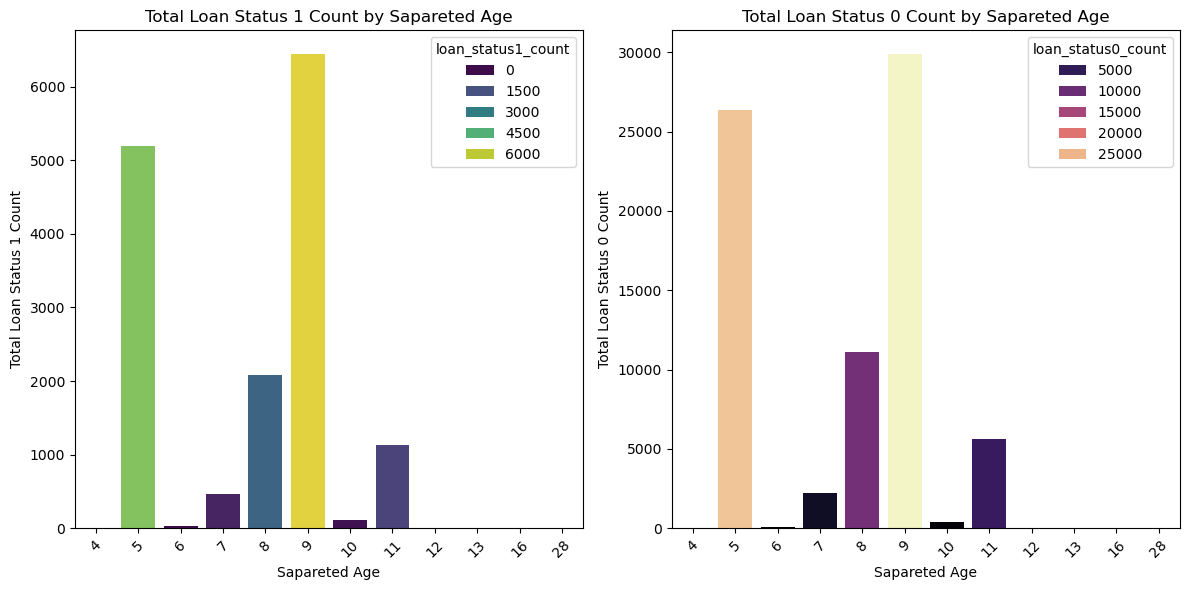

In [94]:
counts_by_age = ages_df.groupby('sapareted_age')[['loan_status1_count', 'loan_status0_count']].sum().reset_index()



plt.figure(figsize=(12, 6))



plt.subplot(1, 2, 1) 

sns.barplot(x='sapareted_age', y='loan_status1_count', data=counts_by_age.to_pandas(),hue='loan_status1_count' , palette='viridis')

plt.title('Total Loan Status 1 Count by Sapareted Age')

plt.xlabel('Sapareted Age')

plt.ylabel('Total Loan Status 1 Count')

plt.xticks(rotation=45)



plt.subplot(1, 2, 2)  

sns.barplot(x='sapareted_age', y='loan_status0_count', data=counts_by_age.to_pandas(), hue='loan_status0_count', palette='magma')

plt.title('Total Loan Status 0 Count by Sapareted Age')

plt.xlabel('Sapareted Age')

plt.ylabel('Total Loan Status 0 Count')

plt.xticks(rotation=45)



plt.tight_layout() 

plt.show()

You can see which range the numbers in the x column represent by multiplying them by 5. For example, take 9; the result of multiplying it by 5 is 45, which represents ages between 45 and 50.

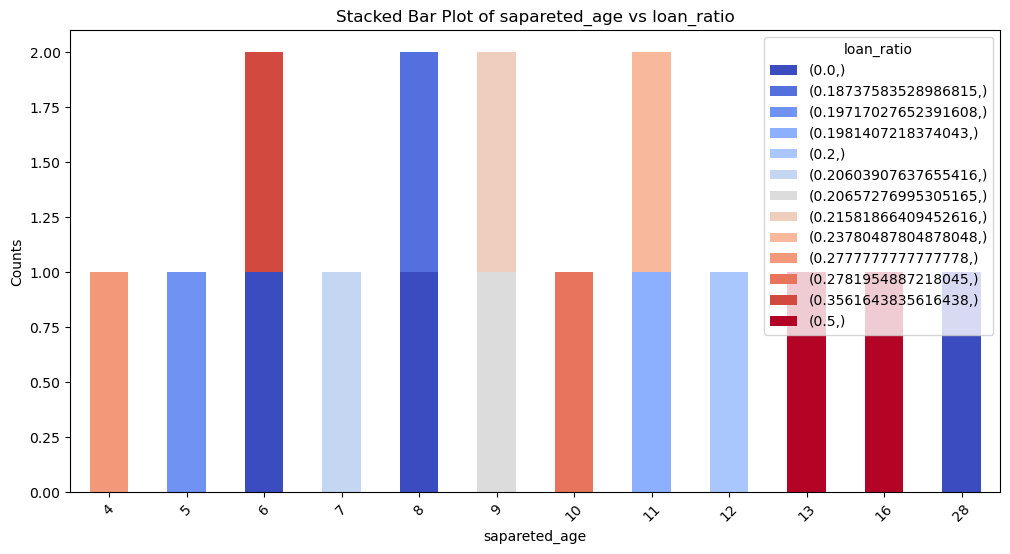

In [95]:
draw_fonk(ages_df,'sapareted_age', target='loan_ratio')

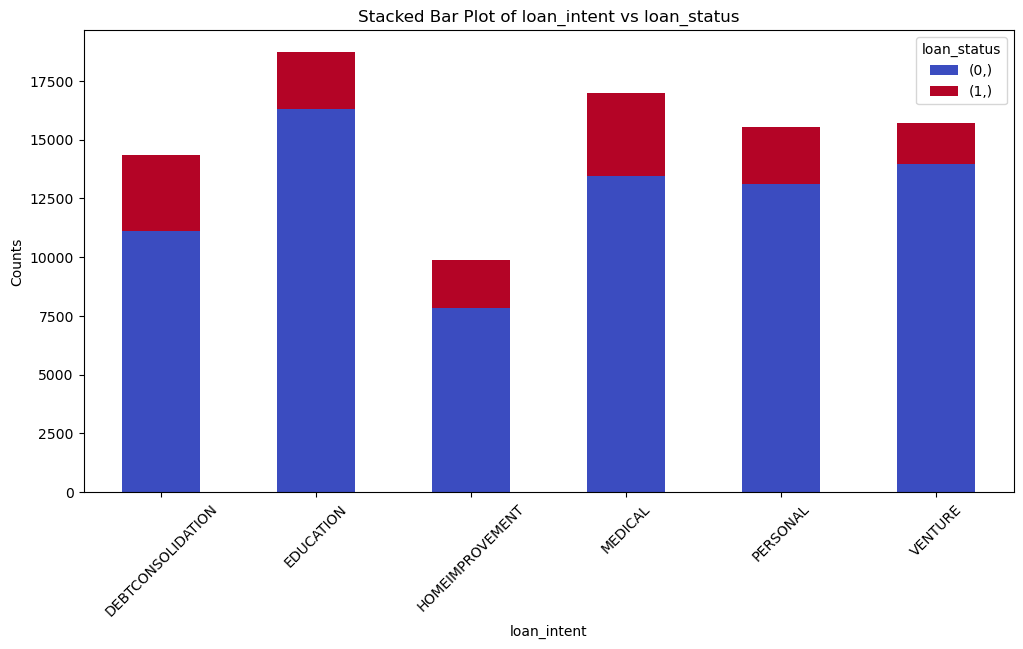

In [96]:
draw_fonk(df, 'loan_intent')

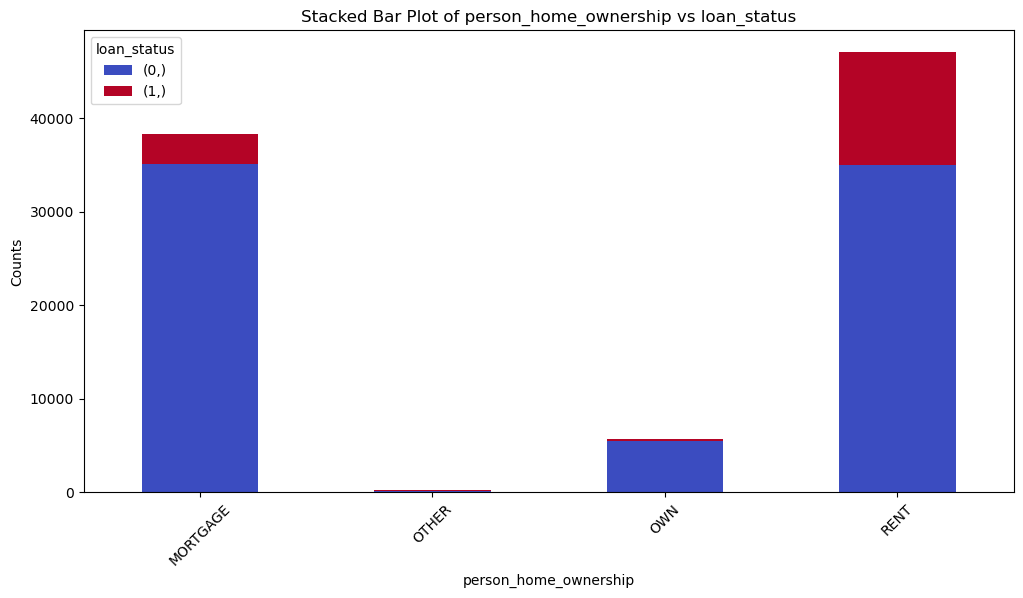

In [97]:
draw_fonk(df, 'person_home_ownership')

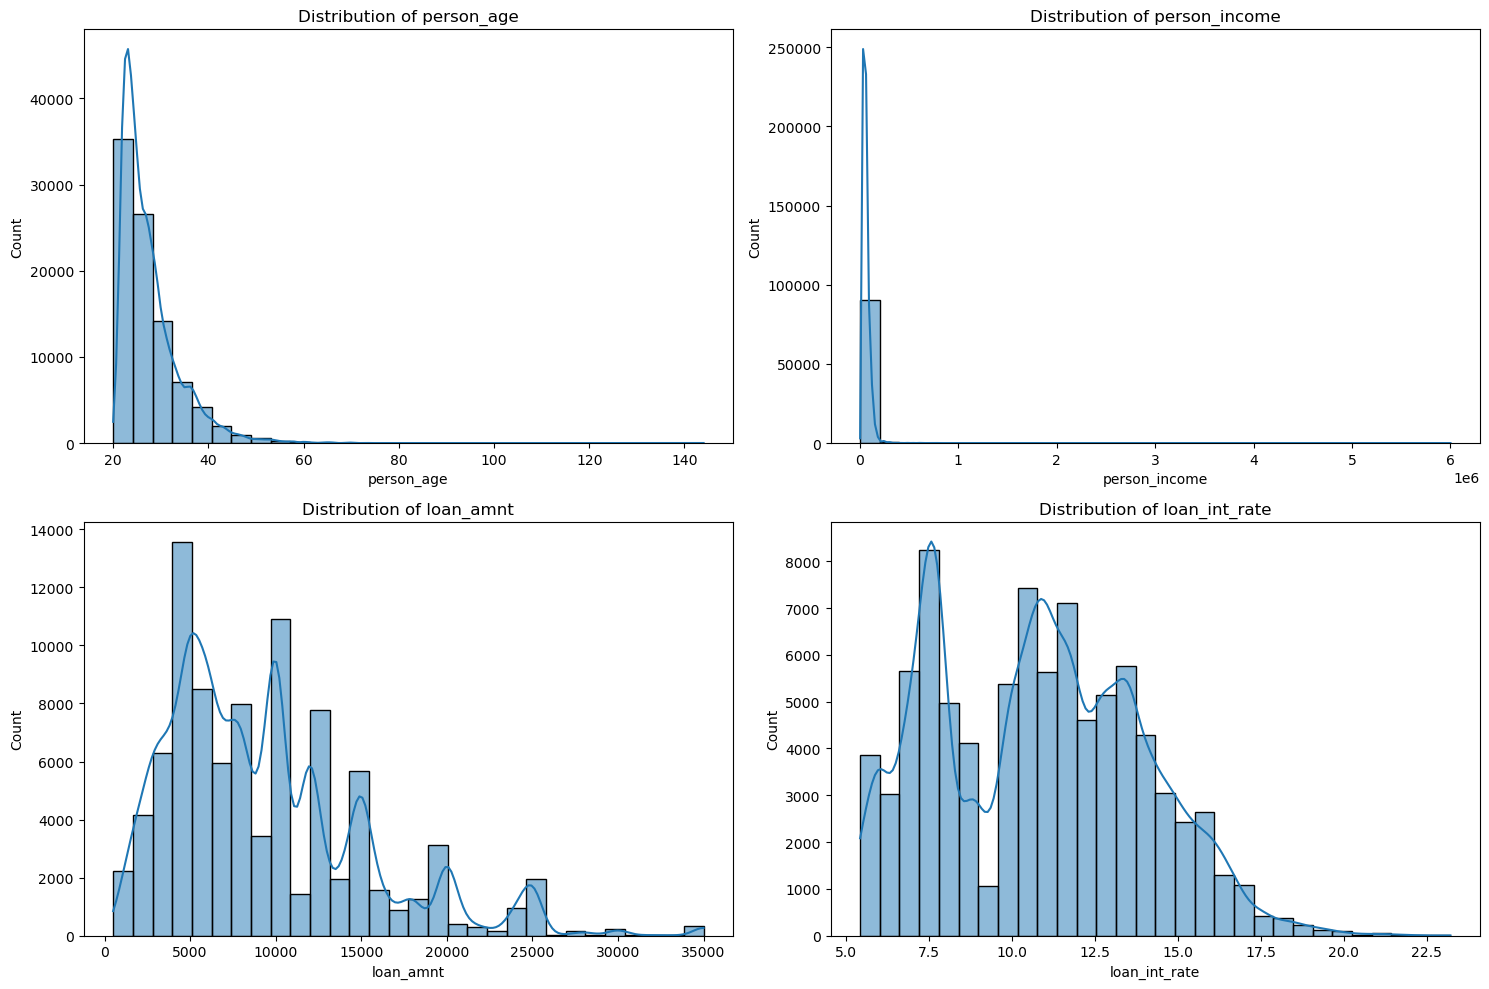

In [98]:
num_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(num_features, 1):

    plt.subplot(2, 2, i)

    sns.histplot(df[feature].to_pandas(), bins=30, kde=True)

    plt.title(f'Distribution of {feature}')

plt.tight_layout()

plt.show()

In [99]:
test = cd.read_csv('test.csv', index_col=False)

test.head()

test_len= len(test)

test['loan_status'] = None

test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2,<NA>
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4,<NA>
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2,<NA>
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7,<NA>
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4,<NA>


In [100]:
df= cd.concat([df,test], ignore_index=True)

df.shape

(130324, 13)

In [101]:
df.isna().sum()

person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length               895
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                  3116
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
loan_status                   39098
id                            91226
dtype: int64

In [102]:
df['person_income'].sort_values(ascending=False)

90942     6000000
88694     2039784
17387     1900000
91191     1900000
125233    1900000
           ...   
86541        4200
118105       4200
74609        4080
90575        4000
98927        4000
Name: person_income, Length: 130324, dtype: int64

In [103]:
df[(df['person_age']>65) & (df['loan_status']==1)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,id
15588,80,54000,RENT,27.0,PERSONAL,A,10000,6.62,0.19,N,25,1,<NA>
16954,76,30000,RENT,2.0,HOMEIMPROVEMENT,D,6500,16.77,0.21,N,24,1,<NA>
21953,80,30000,RENT,7.0,MEDICAL,D,5000,14.96,0.17,N,24,1,<NA>
25499,73,42000,RENT,7.0,PERSONAL,D,13750,14.96,0.32,N,24,1,<NA>
40466,66,24696,RENT,1.0,HOMEIMPROVEMENT,C,8875,13.98,0.36,N,27,1,<NA>
48382,70,17000,RENT,0.0,PERSONAL,B,1500,10.38,0.09,N,21,1,<NA>
53847,70,37000,RENT,2.0,PERSONAL,B,3000,10.37,0.08,N,21,1,<NA>
90954,66,60000,RENT,4.0,MEDICAL,C,27050,<NA>,0.45,Y,28,1,<NA>
90962,66,43000,RENT,17.0,DEBTCONSOLIDATION,D,22250,14.59,0.52,Y,23,1,<NA>
90979,70,30000,RENT,0.0,DEBTCONSOLIDATION,D,1000,17.49,0.03,Y,21,1,<NA>


In [104]:
df[df['person_income']>1000000]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,id
2093,32,1200000,RENT,2.0,PERSONAL,A,10000,7.51,0.01,N,9,0,<NA>
12404,25,1839784,RENT,0.0,VENTURE,A,8000,8.0,0.04,N,3,0,<NA>
17387,22,1900000,MORTGAGE,6.0,EDUCATION,D,1500,15.62,0.00,Y,3,0,<NA>
19060,32,1200000,MORTGAGE,16.0,DEBTCONSOLIDATION,A,16000,6.92,0.13,N,5,0,<NA>
37591,29,1824000,MORTGAGE,8.0,DEBTCONSOLIDATION,C,6000,13.99,0.03,N,6,0,<NA>
76478,32,1200000,MORTGAGE,1.0,VENTURE,A,12000,7.51,0.01,N,8,0,<NA>
87764,36,1200000,OWN,16.0,MEDICAL,A,10000,6.54,0.01,N,11,0,<NA>
87765,40,1200000,MORTGAGE,1.0,MEDICAL,A,10000,<NA>,0.01,N,16,0,<NA>
88694,42,2039784,RENT,0.0,VENTURE,C,8450,12.29,0.00,Y,15,0,<NA>
90567,47,1362000,MORTGAGE,9.0,VENTURE,A,6600,7.74,0.00,N,17,0,<NA>


In [105]:
df.drop(columns='id', inplace=True)

In [106]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 130324 entries, 0 to 130323
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   person_age                  130324 non-null  int64
 1   person_income               130324 non-null  int64
 2   person_home_ownership       130324 non-null  object
 3   person_emp_length           129429 non-null  float64
 4   loan_intent                 130324 non-null  object
 5   loan_grade                  130324 non-null  object
 6   loan_amnt                   130324 non-null  int64
 7   loan_int_rate               127208 non-null  float64
 8   loan_percent_income         130324 non-null  float64
 9   cb_person_default_on_file   130324 non-null  object
 10  cb_person_cred_hist_length  130324 non-null  int64
 11  loan_status                 91226 non-null   int64
dtypes: float64(3), int64(5), object(4)
memory usage: 12.2+ MB


In [107]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# Feature_engineering with RAPIDS

In [108]:
multiplication =['person_income','person_age', 'person_emp_length','loan_amnt', 'loan_int_rate', 'loan_percent_income','cb_person_cred_hist_length']

In [109]:
def duplicate (df,multiplication):

    for i, mult in enumerate(multiplication):

        for j, mult2 in enumerate(multiplication):

            if mult==mult2:

                continue

            elif j<len(multiplication)-1:

                next_value = multiplication[j+1]

                df[mult +'*'+ next_value] = df[mult] * df[next_value]

In [110]:
temp = df.copy()

duplicate(temp, multiplication)

In [111]:
temp.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,loan_percent_income*person_emp_length,loan_percent_income*loan_amnt,loan_percent_income*loan_int_rate,loan_percent_income*loan_percent_income,cb_person_cred_hist_length*person_age,cb_person_cred_hist_length*person_emp_length,cb_person_cred_hist_length*loan_amnt,cb_person_cred_hist_length*loan_int_rate,cb_person_cred_hist_length*loan_percent_income,cb_person_cred_hist_length*cb_person_cred_hist_length
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,...,0.00,1020.0,1.9533,0.0289,518,0.0,84000,160.86,2.38,196
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,...,0.42,280.0,0.9345,0.0049,44,12.0,8000,26.70,0.14,4
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,...,1.68,1260.0,1.8690,0.0441,290,80.0,60000,89.00,2.10,100
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,...,2.38,2040.0,1.8887,0.0289,150,70.0,60000,55.55,0.85,25
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,...,0.20,600.0,0.6920,0.0100,66,6.0,18000,20.76,0.30,9


In [112]:
df = temp.copy()

In [113]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 130324 entries, 0 to 130323
Data columns (total 48 columns):
 #   Column                                                 Non-Null Count   Dtype
---  ------                                                 --------------   -----
 0   person_age                                             130324 non-null  int64
 1   person_income                                          130324 non-null  int64
 2   person_home_ownership                                  130324 non-null  object
 3   person_emp_length                                      129429 non-null  float64
 4   loan_intent                                            130324 non-null  object
 5   loan_grade                                             130324 non-null  object
 6   loan_amnt                                              130324 non-null  int64
 7   loan_int_rate                                          127208 non-null  float64
 8   loan_percent_income                          

## More columns

In [114]:
df['loan_amnt/person_income'] = df['loan_amnt'] / df['person_income']  

In [115]:
df['income/age'] = df['person_income']/df['person_age']

In [143]:
df['person_income/person_emp_length'] = df['person_income'] / (df['person_emp_length'].replace(0,1))

In [117]:
df['cb_person_cred_hist_length/person_age'] = df['cb_person_cred_hist_length'] / df['person_age']

In [118]:
df['loan_int_rate/loan_amnt'] = df['loan_int_rate'] / df['loan_amnt']

In [119]:
df['income*person_emp_length/loan_amnt*loan_int_rate'] = df['loan_amnt/person_income'] *(df['person_emp_length']/df['loan_int_rate'])

In [144]:
df['loan_amnt/cb_person_cred_hist_length'] = df['loan_amnt'] / df['cb_person_cred_hist_length'] 

df['loan_int_rate/cb_person_cred_hist_length'] = df['loan_int_rate'] / df['cb_person_cred_hist_length']  

df['loan_int_rate/person_emp_length'] = df['loan_int_rate'] / (df['person_emp_length'].replace(0, 1))

df['loan_amnt/person_emp_length'] = df['loan_amnt'] / (df['person_emp_length'].replace(0, 1))      

df['person_income/loan_amnt'] = df['person_income'] / df['loan_amnt'] 

In [121]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,income/age,person_income/person_emp_length,cb_person_cred_hist_length/person_age,loan_int_rate/loan_amnt,income*person_emp_length/loan_amnt*loan_int_rate,loan_amnt/cb_person_cred_hist_length,loan_int_rate/cb_person_cred_hist_length,loan_int_rate/person_emp_length,loan_amnt/person_emp_length,person_income/loan_amnt
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,...,945.945946,inf,0.378378,0.001915,0.000000,428.571429,0.820714,11.490000,inf,5.833333
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,...,2545.454545,9.333333e+03,0.090909,0.003338,0.032103,2000.000000,6.675000,2.225000,666.666667,14.000000
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,...,993.103448,3.600000e+03,0.344828,0.001483,0.187266,600.000000,0.890000,1.112500,750.000000,4.800000
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,...,2333.333333,5.000000e+03,0.166667,0.000926,0.216022,2400.000000,2.222000,0.793571,857.142857,5.833333
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,...,2727.272727,3.000000e+04,0.136364,0.001153,0.028902,2000.000000,2.306667,3.460000,3000.000000,10.000000


we should use `map` instead of `apply` because apply method so slow so cudf does not support.


In [122]:
age_map = {True: 'OLD', False: 'NORMAL'}

df['old_person'] = (df['person_age'] >= 65).map(age_map)

# Label encoding

In [123]:
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}

df['emp_length*loan_grade'] = df['person_emp_length'] *df['loan_grade'].map(grade_mapping)

# One-Hot Encoding 

In [124]:
df['person_home_ownership'] = df['person_home_ownership'].astype(str)

In [125]:
df = cd.concat([df, cd.get_dummies(df['person_home_ownership'], prefix='home_ownership', dtype= int)], axis = 1)

df.drop('person_home_ownership', axis=1, inplace = True)

In [126]:
df = cd.concat([df, cd.get_dummies(df['loan_intent'], prefix='loan_intent', dtype= int)], axis = 1)

df.drop('loan_intent', axis=1, inplace = True)

In [127]:
df = cd.concat([df, cd.get_dummies(df['loan_grade'], prefix='loan_grade', dtype= int)], axis = 1)

df.drop('loan_grade', axis=1, inplace = True)

In [128]:
df = cd.concat([df, cd.get_dummies(df['cb_person_default_on_file'], prefix='cb_person_default', dtype= int)], axis = 1)

df.drop('cb_person_default_on_file', axis=1, inplace = True)

In [129]:
df = cd.concat([df, cd.get_dummies(df['old_person'], prefix='old_person', dtype= int)], axis = 1)

df.drop('old_person', axis=1, inplace = True)

In [130]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 130324 entries, 0 to 130323
Data columns (total 77 columns):
 #   Column                                                 Non-Null Count   Dtype
---  ------                                                 --------------   -----
 0   person_age                                             130324 non-null  int64
 1   person_income                                          130324 non-null  int64
 2   person_emp_length                                      129429 non-null  float64
 3   loan_amnt                                              130324 non-null  int64
 4   loan_int_rate                                          127208 non-null  float64
 5   loan_percent_income                                    130324 non-null  float64
 6   cb_person_cred_hist_length                             130324 non-null  int64
 7   loan_status                                            91226 non-null   int64
 8   person_income*person_emp_length               

In [131]:
temp_df = df.iloc[:, :48]

mask = temp_df.nunique() < 3



temp_df.loc[:, mask.to_arrow().to_pandas()]

,loan_status
0,0
1,0
2,0
3,0
4,0
...,...
130319,<NA>
130320,<NA>
130321,<NA>
130322,<NA>


In [132]:
temp_df = temp_df.drop(columns='loan_status')

In [133]:
type(temp_df)

cudf.core.dataframe.DataFrame

In [134]:
temp_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_income*person_emp_length,person_income*loan_amnt,person_income*loan_int_rate,...,cb_person_cred_hist_length*person_age,cb_person_cred_hist_length*person_emp_length,cb_person_cred_hist_length*loan_amnt,cb_person_cred_hist_length*loan_int_rate,cb_person_cred_hist_length*loan_percent_income,cb_person_cred_hist_length*cb_person_cred_hist_length,loan_amnt/person_income,income/age,person_income/person_emp_length,cb_person_cred_hist_length/person_age
0,37,35000,0.0,6000,11.49,0.17,14,0.0,210000000,402150.0,...,518,0.0,84000,160.86,2.38,196,0.171429,945.945946,inf,0.378378
1,22,56000,6.0,4000,13.35,0.07,2,336000.0,224000000,747600.0,...,44,12.0,8000,26.70,0.14,4,0.071429,2545.454545,9.333333e+03,0.090909
2,29,28800,8.0,6000,8.90,0.21,10,230400.0,172800000,256320.0,...,290,80.0,60000,89.00,2.10,100,0.208333,993.103448,3.600000e+03,0.344828
3,30,70000,14.0,12000,11.11,0.17,5,980000.0,840000000,777700.0,...,150,70.0,60000,55.55,0.85,25,0.171429,2333.333333,5.000000e+03,0.166667
4,22,60000,2.0,6000,6.92,0.10,3,120000.0,360000000,415200.0,...,66,6.0,18000,20.76,0.30,9,0.100000,2727.272727,3.000000e+04,0.136364


In [135]:
cols_for_standard = temp_df.columns

In [136]:
from cuml.preprocessing import StandardScaler

def make_standart(df, columns):

    scaler = StandardScaler()

    for col in columns:

        df[col] = scaler.fit_transform(df[col].to_frame())

    return df

In [142]:
inf_counts = (df == np.inf).sum()



# Her sütundaki inf değerlerinin sayısını yazdır

print(inf_counts[inf_counts > 0])


person_income/person_emp_length    16796
loan_amnt/person_emp_length        16796
dtype: int64


In [145]:
make_standart(df, cols_for_standard)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_income*person_emp_length,person_income*loan_amnt,...,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_N,cb_person_default_Y,old_person_NORMAL,old_person_OLD
0,1.537266,-0.654283,-1.186028,-0.575670,0.240038,0.082688,2.021377,0,-0.670787,-0.580763,...,1,0,0,0,0,0,1,0,1,0
1,-0.916228,-0.189430,0.322111,-0.922387,0.843439,-0.961320,-0.942651,0,0.006664,-0.563349,...,0,1,0,0,0,0,1,0,1,0
2,0.228736,-0.791526,0.824824,-0.575670,-0.600182,0.500291,1.033368,0,-0.206249,-0.627034,...,0,0,0,0,0,0,1,0,1,0
3,0.392302,0.120472,2.332962,0.464483,0.116762,0.082688,-0.201644,0,1.305110,0.202860,...,1,0,0,0,0,0,1,0,1,0
4,-0.916228,-0.100887,-0.683315,-0.575670,-1.242512,-0.648117,-0.695649,0,-0.428840,-0.394186,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130319,-0.916228,-0.738400,-0.683315,-1.095746,-0.123300,-0.648117,-0.448647,<NA>,-0.544975,-0.725546,...,1,0,0,0,0,0,1,0,1,0
130320,-0.916228,-0.366517,0.322111,-0.402311,-1.531236,-0.126113,-0.695649,<NA>,-0.090115,-0.424038,...,0,0,0,0,0,0,1,0,1,0
130321,3.827192,-0.100887,-1.186028,0.984559,-1.051110,0.917894,4.738403,<NA>,-0.670787,0.277490,...,0,0,0,0,0,0,1,0,1,0
130322,-0.916228,-0.632148,-0.180602,0.811201,1.579847,2.379505,-0.448647,<NA>,-0.380451,-0.215072,...,0,0,1,0,0,0,0,1,1,0


In [146]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 130324 entries, 0 to 130323
Data columns (total 77 columns):
 #   Column                                                 Non-Null Count   Dtype
---  ------                                                 --------------   -----
 0   person_age                                             130324 non-null  float64
 1   person_income                                          130324 non-null  float64
 2   person_emp_length                                      129429 non-null  float64
 3   loan_amnt                                              130324 non-null  float64
 4   loan_int_rate                                          127208 non-null  float64
 5   loan_percent_income                                    130324 non-null  float64
 6   cb_person_cred_hist_length                             130324 non-null  float64
 7   loan_status                                            91226 non-null   int64
 8   person_income*person_emp_length       

In [147]:
df = df.fillna(0)

Converting all columns to `float32` with cudf before performing machine learning is a common practice to increase memory efficiency, optimize performance, and meet the requirements of the model.

In [148]:
df = df.astype('float32')

In [149]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 130324 entries, 0 to 130323
Data columns (total 77 columns):
 #   Column                                                 Non-Null Count   Dtype
---  ------                                                 --------------   -----
 0   person_age                                             130324 non-null  float32
 1   person_income                                          130324 non-null  float32
 2   person_emp_length                                      130324 non-null  float32
 3   loan_amnt                                              130324 non-null  float32
 4   loan_int_rate                                          130324 non-null  float32
 5   loan_percent_income                                    130324 non-null  float32
 6   cb_person_cred_hist_length                             130324 non-null  float32
 7   loan_status                                            130324 non-null  float32
 8   person_income*person_emp_length     

As seen, before converting to `float32`, the size was 77.0 MB, and now it is 38.3 MB.

## Modeling

In [150]:
test = df.tail(test_len)

In [151]:
test['loan_status'].unique()

0    0.0
Name: loan_status, dtype: float32

In [152]:
test.drop(columns='loan_status', inplace=True)

In [157]:
train = df.iloc[:(len(df)-test_len)]

train['loan_status'].unique()

0    0.0
1    1.0
Name: loan_status, dtype: float32

In [158]:
len(train)

91226

In [160]:
X = train.drop(columns='loan_status', axis=1)

y = train['loan_status']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [190]:
def creat_primitive_model(model, model_name, X_train = X_train.to_numpy(), X_test = X_test.to_numpy(), y_train = y_train.to_numpy(), y_test = y_test.to_numpy()):



    model.fit(X_train, y_train)



    y_pred = model.predict(X_test)



    accuracy = accuracy_score(y_test, y_pred)



    roc_auc = roc_auc_score(y_test, y_pred)



    

    print(f"\n{model_name} Model:")

    print(f"Accuracy: {accuracy}")

    print(f"ROC AUC: {roc_auc}")

    

    return accuracy, roc_auc




In [191]:
models = {

    "Random Forest": RandomForestClassifier(),

    "XGBoost": XGBClassifier(tree_method='hist', device='cuda'),

    "LightGBM": lgb.LGBMClassifier(device='cuda'),

    "CatBoost": cb.CatBoostClassifier(task_type='GPU', verbose=0),

}

results = {}



for model_name, model in models.items():



  accuracy, roc_auc = creat_primitive_model(model, model_name)



  results[model_name] = {"accuracy": accuracy, "roc_auc": roc_auc} 


Random Forest Model:
Accuracy: 0.9414634108543396
ROC AUC: 0.8441942930221558

XGBoost Model:
Accuracy: 0.9453001022338867
ROC AUC: 0.8633936643600464
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 12297, number of negative: 60684
[LightGBM] [Info] Total Bins 12022
[LightGBM] [Info] Number of data points in the train set: 72981, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168496 -> initscore=-1.596325
[LightGBM] [Info] Start training from score -1.596325

LightGBM Model:
Accuracy: 0.9461770057678223
ROC AUC: 0.8594229817390442



CatBoost Model:
Accuracy: 0.9467251300811768
ROC AUC: 0.8597545027732849


In [201]:
accuracy_values = {"xgb": 0, "lightgbm": 0, "cat": 0}

# XGBoost

In [221]:
def objective(trial):

    params = {

        'objective': 'binary:logistic',

        'eval_metric': 'logloss',

        'tree_method': 'hist', 

        'device': 'cuda', #To activate GPU

        'eta': trial.suggest_float('eta', 0.01, 0.3),  

        'max_depth': trial.suggest_int('max_depth', 3, 9),

        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),

        'gamma': trial.suggest_float('gamma', 0.0, 0.5),

        'subsample': trial.suggest_float('subsample', 0.5, 1.0),

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),

        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),

        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),

        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)

    }



    cv = StratifiedKFold(5, shuffle=True, random_state=0)

    cv_splits = cv.split(X.to_pandas(), y.to_pandas())

    roc_auc_scores = []

    for train_idx, val_idx in cv_splits:

        X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]

        y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]

        

        xgb_model = XGBClassifier(**params)

        xgb_model.fit(X_train_fold, y_train_fold)

        #y_pred = xgb_model.predict(X_val_fold)

        y_pred_proba_val = xgb_model.predict_proba(X_val_fold)[:, 1]  # Get probabilities for roc_auc

        

        accuracy_values['xgb'] = accuracy_score(y_val_fold, y_pred_proba_val)

        print(f'accuracy score for xgboost: {accuracy_values["xgb"]}')

        

        roc_auc = roc_auc_score(y_val_fold, y_pred_proba_val)

        roc_auc_scores.append(roc_auc)

        print(f'roc_auc_score{roc_auc}')



    mean_roc_auc = sum(roc_auc_scores) / len(roc_auc_scores)

    print(f'Mean roc_auc_score across folds: {mean_roc_auc}')



    return mean_roc_auc 

In [222]:
type(X_train)

cudf.core.dataframe.DataFrame

In [223]:
study = optuna.create_study( study_name='XGBoost', 

                             sampler=TPESampler(n_startup_trials=100, seed=42),

                             direction="maximize")

study.optimize(objective, n_trials=100)

print(f"best optimized roc-auc: {study.best_value:0.5f}") 

print(f"best hyperparameters: {study.best_params}") 



# En iyi hiperparametreleri yazdırın

print('Best trial:')

trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')

for key, value in trial.params.items():

    print('    {}: {}'.format(key, value))


[I 2024-10-22 19:23:53,269] A new study created in memory with name: XGBoost


accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9448264241218567
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9505847692489624
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9433098435401917
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9442342519760132


[I 2024-10-22 19:24:23,036] Trial 0 finished with value: 0.9461512446403504 and parameters: {'eta': 0.11861663446573512, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 0.2993292420985183, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'lambda': 0.05808362158736334, 'alpha': 0.8661761471131737, 'n_estimators': 641}. Best is trial 0 with value: 0.9461512446403504.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9478009343147278
Mean roc_auc_score across folds: 0.9461512446403504
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9499512314796448
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9540479779243469
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9485241770744324
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9497171640396118


[I 2024-10-22 19:24:31,664] Trial 1 finished with value: 0.9505692481994629 and parameters: {'eta': 0.21534104756085318, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.41622132040021087, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'lambda': 0.1834045180193887, 'alpha': 0.3042422499171153, 'n_estimators': 572}. Best is trial 1 with value: 0.9505692481994629.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9506056904792786
Mean roc_auc_score across folds: 0.9505692481994629
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9521121382713318
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9556290507316589
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9512630701065063
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.950732946395874


[I 2024-10-22 19:24:38,582] Trial 2 finished with value: 0.9528207778930664 and parameters: {'eta': 0.13526405540621358, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.06974693032602092, 'subsample': 0.6460723242676091, 'colsample_bytree': 0.6831809216468459, 'lambda': 0.45606998965633605, 'alpha': 0.785175963541254, 'n_estimators': 279}. Best is trial 2 with value: 0.9528207778930664.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9543666839599609
Mean roc_auc_score across folds: 0.9528207778930664
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9436150789260864
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9510243535041809
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9435951113700867
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9436588287353516


[I 2024-10-22 19:25:11,737] Trial 3 finished with value: 0.9460302710533142 and parameters: {'eta': 0.15912798713994736, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.3037724259507192, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'lambda': 0.9488855377644779, 'alpha': 0.965632033418239, 'n_estimators': 828}. Best is trial 2 with value: 0.9528207778930664.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9482579827308655
Mean roc_auc_score across folds: 0.9460302710533142
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9454123973846436
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9500517845153809
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9451923966407776
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9460505843162537


[I 2024-10-22 19:25:17,355] Trial 4 finished with value: 0.9472901821136475 and parameters: {'eta': 0.09833799306027749, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.22007624686980065, 'subsample': 0.5610191174223894, 'colsample_bytree': 0.7475884550556351, 'lambda': 0.034388530771333185, 'alpha': 0.909320402985578, 'n_estimators': 333}. Best is trial 2 with value: 0.9528207778930664.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9497437477111816
Mean roc_auc_score across folds: 0.9472901821136475
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9459953904151917
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9498128890991211
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9440677165985107
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9454306364059448


[I 2024-10-22 19:25:39,516] Trial 5 finished with value: 0.9467337965965271 and parameters: {'eta': 0.20213146246265476, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.2733551396716398, 'subsample': 0.5924272277627636, 'colsample_bytree': 0.9847923138822793, 'lambda': 0.7751328256097864, 'alpha': 0.9394989421691997, 'n_estimators': 906}. Best is trial 2 with value: 0.9528207778930664.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9483623504638672
Mean roc_auc_score across folds: 0.9467337965965271
accuracy score for xgboost: 0.8305929899215698
roc_auc_score0.942119836807251
accuracy score for xgboost: 0.8306385278701782
roc_auc_score0.9478803873062134
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9410569071769714
accuracy score for xgboost: 0.8306385278701782
roc_auc_score0.9394471049308777


[I 2024-10-22 19:26:23,226] Trial 6 finished with value: 0.9432841777801514 and parameters: {'eta': 0.18339099385521468, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.0979914312095726, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'lambda': 0.3886772958027091, 'alpha': 0.2713490390604056, 'n_estimators': 846}. Best is trial 2 with value: 0.9528207778930664.


accuracy score for xgboost: 0.8306933641433716
roc_auc_score0.9459166526794434
Mean roc_auc_score across folds: 0.9432841777801514
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9513217806816101
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9556711912155151
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.951251745223999
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9516543745994568


[I 2024-10-22 19:26:28,890] Trial 7 finished with value: 0.9527342319488525 and parameters: {'eta': 0.11345846474114088, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.07046211248738132, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.5372753218398854, 'lambda': 0.986886936731648, 'alpha': 0.7722447715742098, 'n_estimators': 279}. Best is trial 2 with value: 0.9528207778930664.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9537720680236816
Mean roc_auc_score across folds: 0.9527342319488525
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9525648951530457
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9573589563369751
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.952504575252533
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9516260623931885


[I 2024-10-22 19:27:05,276] Trial 8 finished with value: 0.953537666797638 and parameters: {'eta': 0.011601413965844696, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 0.36450358402049365, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'lambda': 0.3584657349596153, 'alpha': 0.1158690683664391, 'n_estimators': 877}. Best is trial 8 with value: 0.953537666797638.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9536338448524475
Mean roc_auc_score across folds: 0.953537666797638
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9480980634689331
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9550950527191162
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9483232498168945
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9485061764717102


[I 2024-10-22 19:27:19,547] Trial 9 finished with value: 0.9498794674873352 and parameters: {'eta': 0.19075645677999178, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.1554911608578311, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'lambda': 0.6375574749796384, 'alpha': 0.8872127437041991, 'n_estimators': 525}. Best is trial 8 with value: 0.953537666797638.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.949374794960022
Mean roc_auc_score across folds: 0.9498794674873352
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9459388852119446
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9512949585914612
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9468463063240051
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9462383985519409


[I 2024-10-22 19:27:25,298] Trial 10 finished with value: 0.9478348970413208 and parameters: {'eta': 0.04468233132210749, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.2806385987847481, 'subsample': 0.8854835899772805, 'colsample_bytree': 0.7468977981821954, 'lambda': 0.5227328341546658, 'alpha': 0.42754102408313943, 'n_estimators': 122}. Best is trial 8 with value: 0.953537666797638.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9488559365272522
Mean roc_auc_score across folds: 0.9478348970413208
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9464642405509949
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9508730173110962
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9469707608222961
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9485476613044739


[I 2024-10-22 19:27:37,506] Trial 11 finished with value: 0.948499321937561 and parameters: {'eta': 0.04128851382805829, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.15717799053816334, 'subsample': 0.7542853455823514, 'colsample_bytree': 0.9537832369630466, 'lambda': 0.24929223665595263, 'alpha': 0.41038292893180045, 'n_estimators': 780}. Best is trial 8 with value: 0.953537666797638.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9496409296989441
Mean roc_auc_score across folds: 0.948499321937561
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9525680541992188
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9570884108543396
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9515594840049744
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.952767550945282


[I 2024-10-22 19:27:50,560] Trial 12 finished with value: 0.9536714792251587 and parameters: {'eta': 0.0763514679925705, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.08061064362700221, 'subsample': 0.9648488261712865, 'colsample_bytree': 0.9040601897822085, 'lambda': 0.6334037601763859, 'alpha': 0.8714605914731118, 'n_estimators': 824}. Best is trial 12 with value: 0.9536714792251587.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9543738961219788
Mean roc_auc_score across folds: 0.9536714792251587
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9527494311332703
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9588503241539001
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9537876844406128
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.952479362487793


[I 2024-10-22 19:28:13,984] Trial 13 finished with value: 0.9545820832252503 and parameters: {'eta': 0.06410531707695039, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.40372007758203127, 'subsample': 0.9480456499617467, 'colsample_bytree': 0.6590017374859319, 'lambda': 0.11005193342715751, 'alpha': 0.22793517026259005, 'n_estimators': 484}. Best is trial 13 with value: 0.9545820832252503.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.955043613910675
Mean roc_auc_score across folds: 0.9545820832252503
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9442938566207886
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9497674107551575
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9427798986434937
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9443767666816711


[I 2024-10-22 19:28:41,884] Trial 14 finished with value: 0.945678961277008 and parameters: {'eta': 0.247224282117523, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.25537365128878287, 'subsample': 0.7087055015743895, 'colsample_bytree': 0.6110539052353652, 'lambda': 0.11986537613502912, 'alpha': 0.3376151780274762, 'n_estimators': 949}. Best is trial 13 with value: 0.9545820832252503.


accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9471768736839294
Mean roc_auc_score across folds: 0.945678961277008
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9543696641921997
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9587184190750122
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9535143375396729
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9526174068450928


[I 2024-10-22 19:28:53,487] Trial 15 finished with value: 0.9549246907234192 and parameters: {'eta': 0.10372885028601901, 'max_depth': 6, 'min_child_weight': 8, 'gamma': 0.181814801189647, 'subsample': 0.9858910413604803, 'colsample_bytree': 0.9812236474710556, 'lambda': 0.2517823033075412, 'alpha': 0.49724851091990036, 'n_estimators': 371}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9554036259651184
Mean roc_auc_score across folds: 0.9549246907234192
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9397314786911011
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9431369304656982
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9393588304519653
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9414787888526917


[I 2024-10-22 19:28:57,758] Trial 16 finished with value: 0.9415291309356689 and parameters: {'eta': 0.0926037433694656, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.25133951161443074, 'subsample': 0.5257393756249946, 'colsample_bytree': 0.6393232321183058, 'lambda': 0.9082658868839948, 'alpha': 0.2395618982713535, 'n_estimators': 230}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9439396262168884
Mean roc_auc_score across folds: 0.9415291309356689
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9489375948905945
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.955130934715271
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9491325616836548
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9489200711250305


[I 2024-10-22 19:29:22,931] Trial 17 finished with value: 0.9507545113563538 and parameters: {'eta': 0.15194130048049329, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.3360677737029393, 'subsample': 0.8808098076643588, 'colsample_bytree': 0.6188187719961998, 'lambda': 0.7282163513296961, 'alpha': 0.36778313904142185, 'n_estimators': 669}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.951651394367218
Mean roc_auc_score across folds: 0.9507545113563538
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.944995641708374
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.951734721660614
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9440591931343079
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9444741010665894


[I 2024-10-22 19:29:43,687] Trial 18 finished with value: 0.946837556362152 and parameters: {'eta': 0.19372361612065947, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.417651247794619, 'subsample': 0.6603900324858679, 'colsample_bytree': 0.5932592551999272, 'lambda': 0.0407751511470125, 'alpha': 0.5908929472793124, 'n_estimators': 710}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9489241242408752
Mean roc_auc_score across folds: 0.946837556362152
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9335135817527771
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9390491247177124
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9349402785301208
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9340247511863708


[I 2024-10-22 19:29:51,215] Trial 19 finished with value: 0.9359041333198548 and parameters: {'eta': 0.014810470389078283, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.32258639520472493, 'subsample': 0.5871832145024958, 'colsample_bytree': 0.845468869051233, 'lambda': 0.3867353524331839, 'alpha': 0.9367299893694346, 'n_estimators': 223}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9379929304122925
Mean roc_auc_score across folds: 0.9359041333198548
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9501031041145325
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9535490274429321
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9487352967262268
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9500061273574829


[I 2024-10-22 19:29:59,924] Trial 20 finished with value: 0.95100998878479 and parameters: {'eta': 0.10890924180457495, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.4386696766904905, 'subsample': 0.6289708138575778, 'colsample_bytree': 0.8299920230170895, 'lambda': 0.8172222020289939, 'alpha': 0.5552008160474542, 'n_estimators': 577}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9526563882827759
Mean roc_auc_score across folds: 0.95100998878479
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9514942765235901
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9558603763580322
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9515577554702759
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9521236419677734


[I 2024-10-22 19:30:12,960] Trial 21 finished with value: 0.9528391480445861 and parameters: {'eta': 0.08013716436113098, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.4502090285816652, 'subsample': 0.816550728636634, 'colsample_bytree': 0.6695148955243504, 'lambda': 0.3492095811205651, 'alpha': 0.7259556816106826, 'n_estimators': 908}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9531596899032593
Mean roc_auc_score across folds: 0.9528391480445861
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9427940845489502
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9472687244415283
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9431929588317871
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9435645341873169


[I 2024-10-22 19:30:21,873] Trial 22 finished with value: 0.944021713733673 and parameters: {'eta': 0.267255063036884, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.042069982497524416, 'subsample': 0.5808143570473069, 'colsample_bytree': 0.9492770942635396, 'lambda': 0.6064290635952994, 'alpha': 0.009197061524659132, 'n_estimators': 191}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.943288266658783
Mean roc_auc_score across folds: 0.944021713733673
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9512526988983154
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9567543864250183
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9502772688865662
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9508299231529236


[I 2024-10-22 19:30:27,143] Trial 23 finished with value: 0.9526375889778137 and parameters: {'eta': 0.20241551304133618, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.27436689468329306, 'subsample': 0.8459475988463466, 'colsample_bytree': 0.8259806297513003, 'lambda': 0.22426931721786666, 'alpha': 0.7121792242257436, 'n_estimators': 313}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9540736675262451
Mean roc_auc_score across folds: 0.9526375889778137
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9511975646018982
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.958056628704071
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9512475728988647
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9513721466064453


[I 2024-10-22 19:30:41,665] Trial 24 finished with value: 0.9528676867485046 and parameters: {'eta': 0.10436591246618764, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.42461170524708897, 'subsample': 0.8288064461501716, 'colsample_bytree': 0.7841543016677358, 'lambda': 0.09367477689134479, 'alpha': 0.3677158093822755, 'n_estimators': 338}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9524645209312439
Mean roc_auc_score across folds: 0.9528676867485046
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9512627720832825
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9565131664276123
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9496337175369263
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9498473405838013


[I 2024-10-22 19:31:14,066] Trial 25 finished with value: 0.9519512534141541 and parameters: {'eta': 0.08075699657993422, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.44602327758855664, 'subsample': 0.8155693129986314, 'colsample_bytree': 0.8974056517708242, 'lambda': 0.5026370980788212, 'alpha': 0.5769038888573202, 'n_estimators': 543}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.952499270439148
Mean roc_auc_score across folds: 0.9519512534141541
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9506581425666809
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9559434652328491
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9493132829666138
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9497420191764832


[I 2024-10-22 19:31:57,389] Trial 26 finished with value: 0.9516748785972595 and parameters: {'eta': 0.0666204664614329, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.01215798321572692, 'subsample': 0.822736147953584, 'colsample_bytree': 0.5885553397035245, 'lambda': 0.9404585849483285, 'alpha': 0.9539285774633016, 'n_estimators': 924}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9527174830436707
Mean roc_auc_score across folds: 0.9516748785972595
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9506998658180237
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9556448459625244
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9502298831939697
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9513320922851562


[I 2024-10-22 19:32:04,886] Trial 27 finished with value: 0.9521172165870666 and parameters: {'eta': 0.11734602307407886, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.21409207415865716, 'subsample': 0.9833274095218347, 'colsample_bytree': 0.9818099885446264, 'lambda': 0.8530094569372655, 'alpha': 0.29444889912509675, 'n_estimators': 446}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9526793956756592
Mean roc_auc_score across folds: 0.9521172165870666
accuracy score for xgboost: 0.8305929899215698
roc_auc_score0.9503063559532166
accuracy score for xgboost: 0.8306933641433716
roc_auc_score0.9560351967811584
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9493764638900757
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9493363499641418


[I 2024-10-22 19:32:19,491] Trial 28 finished with value: 0.9511959552764893 and parameters: {'eta': 0.25682963473988846, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.2784006312291751, 'subsample': 0.9680773870803905, 'colsample_bytree': 0.8480148983374864, 'lambda': 0.5700611743887533, 'alpha': 0.09717650279900358, 'n_estimators': 654}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9509254097938538
Mean roc_auc_score across folds: 0.9511959552764893
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9521915912628174
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9544758200645447
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9518205523490906
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.951700747013092


[I 2024-10-22 19:32:25,702] Trial 29 finished with value: 0.9528974294662476 and parameters: {'eta': 0.2971156165302363, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.4386865359639777, 'subsample': 0.8703843088771022, 'colsample_bytree': 0.848507870497634, 'lambda': 0.7024840869622685, 'alpha': 0.3594911576248436, 'n_estimators': 364}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9542984366416931
Mean roc_auc_score across folds: 0.9528974294662476
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9441888332366943
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9505245089530945
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9423636198043823
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9422397017478943


[I 2024-10-22 19:32:51,399] Trial 30 finished with value: 0.9453630685806275 and parameters: {'eta': 0.24471473508876895, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.45662027627823565, 'subsample': 0.7556711994304689, 'colsample_bytree': 0.7507581473435998, 'lambda': 0.7982951809838233, 'alpha': 0.6499639342781258, 'n_estimators': 732}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9474986791610718
Mean roc_auc_score across folds: 0.9453630685806275
accuracy score for xgboost: 0.8306478261947632
roc_auc_score0.9392122030258179
accuracy score for xgboost: 0.8306385278701782
roc_auc_score0.9443562030792236
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9379974603652954
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9383360743522644


[I 2024-10-22 19:33:21,849] Trial 31 finished with value: 0.9407944798469543 and parameters: {'eta': 0.24077987413646929, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.187791476319972, 'subsample': 0.5469909699204345, 'colsample_bytree': 0.789140070498087, 'lambda': 0.035942283437319346, 'alpha': 0.46559802347647994, 'n_estimators': 588}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9440704584121704
Mean roc_auc_score across folds: 0.9407944798469543
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9516643285751343
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9577710032463074
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9522460103034973
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9519011974334717


[I 2024-10-22 19:33:52,221] Trial 32 finished with value: 0.9536253690719605 and parameters: {'eta': 0.09309696311720246, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.01867409437460721, 'subsample': 0.9113002803298291, 'colsample_bytree': 0.6800953207056315, 'lambda': 0.12706052138127966, 'alpha': 0.5222432648323718, 'n_estimators': 793}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9545443058013916
Mean roc_auc_score across folds: 0.9536253690719605
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9496163725852966
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9569224715232849
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9491809606552124
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9494701623916626


[I 2024-10-22 19:34:33,060] Trial 33 finished with value: 0.9516627311706543 and parameters: {'eta': 0.07258809797408451, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.02584086058430385, 'subsample': 0.7656773157840739, 'colsample_bytree': 0.7703175608050532, 'lambda': 0.6374299051239075, 'alpha': 0.7260913364617482, 'n_estimators': 979}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9531236886978149
Mean roc_auc_score across folds: 0.9516627311706543
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.949592113494873
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9542726278305054
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9487054347991943
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9491415023803711


[I 2024-10-22 19:34:53,097] Trial 34 finished with value: 0.9506880283355713 and parameters: {'eta': 0.15972710100734663, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 0.1354161256310371, 'subsample': 0.719485710352818, 'colsample_bytree': 0.5392281906711329, 'lambda': 0.02535075316195008, 'alpha': 0.9626484150514409, 'n_estimators': 853}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9517284631729126
Mean roc_auc_score across folds: 0.9506880283355713
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9490005373954773
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9532741904258728
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.947823166847229
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9474397897720337


[I 2024-10-22 19:35:02,523] Trial 35 finished with value: 0.9495215296745301 and parameters: {'eta': 0.2118325197671724, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.07821852133554302, 'subsample': 0.6251214490822976, 'colsample_bytree': 0.7746133323530602, 'lambda': 0.7145959255541031, 'alpha': 0.6601973801157576, 'n_estimators': 352}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9500699639320374
Mean roc_auc_score across folds: 0.9495215296745301
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9466866850852966
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9532784819602966
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9471672773361206
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9443573355674744


[I 2024-10-22 19:35:08,299] Trial 36 finished with value: 0.9478297352790832 and parameters: {'eta': 0.28691093139232626, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.3058603731171761, 'subsample': 0.709800031213895, 'colsample_bytree': 0.6238654947505787, 'lambda': 0.3559726850915348, 'alpha': 0.757846112885908, 'n_estimators': 112}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.947658896446228
Mean roc_auc_score across folds: 0.9478297352790832
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9438371062278748
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9470374584197998
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9430315494537354
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9441341161727905


[I 2024-10-22 19:35:17,224] Trial 37 finished with value: 0.9446762681007386 and parameters: {'eta': 0.043661065747005706, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.4277302920055036, 'subsample': 0.8518289296900119, 'colsample_bytree': 0.7370869145436626, 'lambda': 0.09783416967265986, 'alpha': 0.4916158802006736, 'n_estimators': 526}. Best is trial 15 with value: 0.9549246907234192.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9453411102294922
Mean roc_auc_score across folds: 0.9446762681007386
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9549396634101868
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9595571160316467
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9540696144104004
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9540843963623047


[I 2024-10-22 19:35:33,740] Trial 38 finished with value: 0.955629301071167 and parameters: {'eta': 0.0602285422739044, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.30792504902610823, 'subsample': 0.8175468254338218, 'colsample_bytree': 0.5226520048860223, 'lambda': 0.374612620880345, 'alpha': 0.6258599194556372, 'n_estimators': 553}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9554957151412964
Mean roc_auc_score across folds: 0.955629301071167
accuracy score for xgboost: 0.8305929899215698
roc_auc_score0.9458023905754089
accuracy score for xgboost: 0.8306385278701782
roc_auc_score0.9519950151443481
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9440646171569824
accuracy score for xgboost: 0.8306385278701782
roc_auc_score0.94334876537323


[I 2024-10-22 19:35:58,228] Trial 39 finished with value: 0.9469575762748719 and parameters: {'eta': 0.25838205394461344, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.03528437370021492, 'subsample': 0.8212096391031578, 'colsample_bytree': 0.513255655270811, 'lambda': 0.5857755854157075, 'alpha': 0.9402302420226551, 'n_estimators': 618}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9495770931243896
Mean roc_auc_score across folds: 0.9469575762748719
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9536333084106445
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9588764905929565
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9535616040229797
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9533231258392334


[I 2024-10-22 19:36:08,506] Trial 40 finished with value: 0.9548118948936463 and parameters: {'eta': 0.12256927859989133, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.27280839465796747, 'subsample': 0.9707324043882626, 'colsample_bytree': 0.6930513189003871, 'lambda': 0.9611905642120085, 'alpha': 0.9053506429025573, 'n_estimators': 276}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.954664945602417
Mean roc_auc_score across folds: 0.9548118948936463
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9169775247573853
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9225378036499023
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9172207117080688
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.918810248374939


[I 2024-10-22 19:36:11,277] Trial 41 finished with value: 0.9192439317703247 and parameters: {'eta': 0.030114777253797978, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.0472214803779642, 'subsample': 0.8415033867081785, 'colsample_bytree': 0.5355943242301144, 'lambda': 0.318975637104005, 'alpha': 0.8448753125207015, 'n_estimators': 120}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9206733703613281
Mean roc_auc_score across folds: 0.9192439317703247
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9522897601127625
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9569575786590576
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9514243602752686
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9513679146766663


[I 2024-10-22 19:36:18,404] Trial 42 finished with value: 0.9531005501747132 and parameters: {'eta': 0.24619585995079138, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.3483685826820753, 'subsample': 0.8144714233899419, 'colsample_bytree': 0.9387360067635264, 'lambda': 0.7350710464531753, 'alpha': 0.8034809323500393, 'n_estimators': 354}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9534631371498108
Mean roc_auc_score across folds: 0.9531005501747132
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9497084617614746
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.955918550491333
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9491664171218872
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9489966630935669


[I 2024-10-22 19:36:54,715] Trial 43 finished with value: 0.9512562274932861 and parameters: {'eta': 0.061457467696119615, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.49525257100033665, 'subsample': 0.7063088384557132, 'colsample_bytree': 0.6860090428963916, 'lambda': 0.7764129629778672, 'alpha': 0.34080354684498243, 'n_estimators': 938}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.952491044998169
Mean roc_auc_score across folds: 0.9512562274932861
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9438093304634094
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9476763010025024
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9427332878112793
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9428467154502869


[I 2024-10-22 19:37:07,122] Trial 44 finished with value: 0.944850492477417 and parameters: {'eta': 0.2589396980344734, 'max_depth': 6, 'min_child_weight': 8, 'gamma': 0.3772714370423412, 'subsample': 0.5515619344179663, 'colsample_bytree': 0.9512764533397833, 'lambda': 0.5052523773953335, 'alpha': 0.826457467843167, 'n_estimators': 388}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9471868276596069
Mean roc_auc_score across folds: 0.944850492477417
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9414076805114746
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9485468864440918
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9415808320045471
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9419451951980591


[I 2024-10-22 19:37:22,061] Trial 45 finished with value: 0.9439235925674438 and parameters: {'eta': 0.26970173626389815, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.45269098820963183, 'subsample': 0.5456433383930668, 'colsample_bytree': 0.6596568187952074, 'lambda': 0.9500619675501852, 'alpha': 0.9506071474314847, 'n_estimators': 616}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9461373686790466
Mean roc_auc_score across folds: 0.9439235925674438
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9511463642120361
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9562935829162598
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9521825313568115
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9519734978675842


[I 2024-10-22 19:37:28,353] Trial 46 finished with value: 0.9531200289726257 and parameters: {'eta': 0.19323279152924178, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.16433227268495798, 'subsample': 0.8362592280385193, 'colsample_bytree': 0.87618726471884, 'lambda': 0.7915790458100581, 'alpha': 0.7896181448983725, 'n_estimators': 182}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.954004168510437
Mean roc_auc_score across folds: 0.9531200289726257
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9532613158226013
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.95835280418396
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9523939490318298
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9523079991340637


[I 2024-10-22 19:37:39,523] Trial 47 finished with value: 0.9542450785636902 and parameters: {'eta': 0.15338188836374864, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.2207652506866885, 'subsample': 0.9438520913791499, 'colsample_bytree': 0.6754575062760393, 'lambda': 0.11706702525693569, 'alpha': 0.14299169062291903, 'n_estimators': 786}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9549093246459961
Mean roc_auc_score across folds: 0.9542450785636902
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9453569650650024
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9492570161819458
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9455260634422302
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9468245506286621


[I 2024-10-22 19:37:42,844] Trial 48 finished with value: 0.9471701145172119 and parameters: {'eta': 0.1892832383617157, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.35048456572956, 'subsample': 0.5363815031820968, 'colsample_bytree': 0.9109300296451781, 'lambda': 0.7062422300940739, 'alpha': 0.08134878982841195, 'n_estimators': 176}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.948885977268219
Mean roc_auc_score across folds: 0.9471701145172119
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9525967240333557
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9581745862960815
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9516385197639465
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9526976346969604


[I 2024-10-22 19:37:47,621] Trial 49 finished with value: 0.9535736680030823 and parameters: {'eta': 0.29612547776534087, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.4063997836287513, 'subsample': 0.9736242886919293, 'colsample_bytree': 0.9930005319114354, 'lambda': 0.7533781877251597, 'alpha': 0.37625959176831986, 'n_estimators': 175}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9527608752250671
Mean roc_auc_score across folds: 0.9535736680030823
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9458942413330078
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9517491459846497
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9461739659309387
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.94529128074646


[I 2024-10-22 19:37:52,484] Trial 50 finished with value: 0.9475816488265991 and parameters: {'eta': 0.23537260561895665, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.453177192547368, 'subsample': 0.5555987411530756, 'colsample_bytree': 0.7463125521454296, 'lambda': 0.011353654653882621, 'alpha': 0.46866064730751983, 'n_estimators': 150}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9487996101379395
Mean roc_auc_score across folds: 0.9475816488265991
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9487922787666321
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9528374671936035
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9487353563308716
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9498712420463562


[I 2024-10-22 19:38:05,184] Trial 51 finished with value: 0.950302517414093 and parameters: {'eta': 0.04445719571774086, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.37302243963271164, 'subsample': 0.7916843825485798, 'colsample_bytree': 0.981086274237271, 'lambda': 0.37487058577499827, 'alpha': 0.28571209342473985, 'n_estimators': 882}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9512762427330017
Mean roc_auc_score across folds: 0.950302517414093
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9495963454246521
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9547524452209473
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9489830136299133
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9491163492202759


[I 2024-10-22 19:38:18,144] Trial 52 finished with value: 0.9507714509963989 and parameters: {'eta': 0.07484279317064126, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.4849394133538195, 'subsample': 0.5215799559752881, 'colsample_bytree': 0.9455715568490355, 'lambda': 0.5277011138092887, 'alpha': 0.9929647961896524, 'n_estimators': 166}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.951409101486206
Mean roc_auc_score across folds: 0.9507714509963989
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9480530023574829
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9528759717941284
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9473752379417419
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9468561410903931


[I 2024-10-22 19:38:51,021] Trial 53 finished with value: 0.9491799950599671 and parameters: {'eta': 0.17061774247638303, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.31469931906763127, 'subsample': 0.8478743444923086, 'colsample_bytree': 0.7272705323838866, 'lambda': 0.6275580838084827, 'alpha': 0.5843143160799571, 'n_estimators': 911}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9507396221160889
Mean roc_auc_score across folds: 0.9491799950599671
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9423953890800476
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9471441507339478
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9436599612236023
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9442945718765259


[I 2024-10-22 19:39:01,267] Trial 54 finished with value: 0.9447163939476013 and parameters: {'eta': 0.023179450299022783, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.44513189194545816, 'subsample': 0.7278283763928565, 'colsample_bytree': 0.8100662989007683, 'lambda': 0.2773811902073208, 'alpha': 0.1881211678425497, 'n_estimators': 517}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9460878968238831
Mean roc_auc_score across folds: 0.9447163939476013
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9534755349159241
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9590997099876404
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9541836977005005
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9529988169670105


[I 2024-10-22 19:39:19,906] Trial 55 finished with value: 0.9550855278968811 and parameters: {'eta': 0.11247214612755531, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.48719740383308324, 'subsample': 0.9931053722398014, 'colsample_bytree': 0.8490808570098726, 'lambda': 0.5360963709831568, 'alpha': 0.30952762319105154, 'n_estimators': 833}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9556698799133301
Mean roc_auc_score across folds: 0.9550855278968811
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.951956570148468
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9576635956764221
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9527641534805298
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9512714743614197


[I 2024-10-22 19:39:37,025] Trial 56 finished with value: 0.9533172845840454 and parameters: {'eta': 0.208572040040625, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.4112686214615845, 'subsample': 0.974899956645962, 'colsample_bytree': 0.86285975419418, 'lambda': 0.613415199801638, 'alpha': 0.41824304210818847, 'n_estimators': 940}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9529306292533875
Mean roc_auc_score across folds: 0.9533172845840454
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9522071480751038
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9577763676643372
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9525530934333801
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9508504271507263


[I 2024-10-22 19:39:44,976] Trial 57 finished with value: 0.9535542726516724 and parameters: {'eta': 0.2611585279551184, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.1882316834390248, 'subsample': 0.9052766653909164, 'colsample_bytree': 0.9936380646574723, 'lambda': 0.15041689959935925, 'alpha': 0.594130719410828, 'n_estimators': 443}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9543843269348145
Mean roc_auc_score across folds: 0.9535542726516724
accuracy score for xgboost: 0.8305929899215698
roc_auc_score0.941923975944519
accuracy score for xgboost: 0.8306933641433716
roc_auc_score0.9468575716018677
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9389681816101074
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9412329196929932


[I 2024-10-22 19:40:15,419] Trial 58 finished with value: 0.9426697611808776 and parameters: {'eta': 0.29127517536623493, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.23434657989748514, 'subsample': 0.7074097511688326, 'colsample_bytree': 0.6367035359653531, 'lambda': 0.05637550608717215, 'alpha': 0.8647223776078294, 'n_estimators': 832}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9443661570549011
Mean roc_auc_score across folds: 0.9426697611808776
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9469550848007202
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9525307416915894
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9471513032913208
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9469634890556335


[I 2024-10-22 19:40:25,580] Trial 59 finished with value: 0.9484787702560424 and parameters: {'eta': 0.29991812525297784, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.38449370759025525, 'subsample': 0.9723828649412141, 'colsample_bytree': 0.9248236953387057, 'lambda': 0.24734810926971662, 'alpha': 0.45054414080465216, 'n_estimators': 216}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9487932324409485
Mean roc_auc_score across folds: 0.9484787702560424
accuracy score for xgboost: 0.8305929899215698
roc_auc_score0.9452823996543884
accuracy score for xgboost: 0.8306385278701782
roc_auc_score0.9518292546272278
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9449190497398376
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9457730054855347


[I 2024-10-22 19:40:43,663] Trial 60 finished with value: 0.9470731616020203 and parameters: {'eta': 0.2866747979050295, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.33585034220292836, 'subsample': 0.8090641202289479, 'colsample_bytree': 0.6790813590164202, 'lambda': 0.11355760106405309, 'alpha': 0.6715731988770677, 'n_estimators': 568}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9475620985031128
Mean roc_auc_score across folds: 0.9470731616020203
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9504624009132385
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9555573463439941
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9494376182556152
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9500976800918579


[I 2024-10-22 19:40:48,187] Trial 61 finished with value: 0.9514618635177612 and parameters: {'eta': 0.2339723336033354, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.27595341938724277, 'subsample': 0.7804689857676932, 'colsample_bytree': 0.9383268013291726, 'lambda': 0.40348287217756834, 'alpha': 0.13401523711048843, 'n_estimators': 125}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9517542719841003
Mean roc_auc_score across folds: 0.9514618635177612
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9417220950126648
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9480115175247192
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9412243962287903
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9409835338592529


[I 2024-10-22 19:41:03,390] Trial 62 finished with value: 0.9437508106231689 and parameters: {'eta': 0.2289898041453495, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.10648208075445537, 'subsample': 0.5681857377933849, 'colsample_bytree': 0.507272332833941, 'lambda': 0.3505875653007214, 'alpha': 0.5899176909554562, 'n_estimators': 453}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9468125104904175
Mean roc_auc_score across folds: 0.9437508106231689
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9481866955757141
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9555659890174866
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9486438035964966
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9488455653190613


[I 2024-10-22 19:41:37,086] Trial 63 finished with value: 0.9504797101020813 and parameters: {'eta': 0.13686772738688144, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.2569947445799054, 'subsample': 0.8918265063705715, 'colsample_bytree': 0.6982713911606351, 'lambda': 0.6220867040070065, 'alpha': 0.8623637101231081, 'n_estimators': 955}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.951156497001648
Mean roc_auc_score across folds: 0.9504797101020813
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9507561922073364
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9564632773399353
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9508231282234192
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9506898522377014


[I 2024-10-22 19:42:13,771] Trial 64 finished with value: 0.952342438697815 and parameters: {'eta': 0.052651309469421, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.12912219414947917, 'subsample': 0.7295678781191306, 'colsample_bytree': 0.9900162876427385, 'lambda': 0.49261809906668863, 'alpha': 0.3287516169999921, 'n_estimators': 670}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9529797434806824
Mean roc_auc_score across folds: 0.952342438697815
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9450063705444336
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9495301246643066
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9441936016082764
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9453256130218506


[I 2024-10-22 19:42:20,233] Trial 65 finished with value: 0.9465515375137329 and parameters: {'eta': 0.07964222944567598, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.06402291947888622, 'subsample': 0.5759513467561472, 'colsample_bytree': 0.5694135863247051, 'lambda': 0.6408747483944671, 'alpha': 0.18188009258034396, 'n_estimators': 411}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9487019777297974
Mean roc_auc_score across folds: 0.9465515375137329
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9437116980552673
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9525336027145386
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9434937238693237
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9444260597229004


[I 2024-10-22 19:42:28,073] Trial 66 finished with value: 0.9461672902107239 and parameters: {'eta': 0.2700686388727434, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.08615993560081492, 'subsample': 0.5961445094043354, 'colsample_bytree': 0.5204343081332394, 'lambda': 0.1689350713828139, 'alpha': 0.2785903462460552, 'n_estimators': 259}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9466713666915894
Mean roc_auc_score across folds: 0.9461672902107239
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9459401965141296
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9491679072380066
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.945591151714325
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9463284015655518


[I 2024-10-22 19:42:40,530] Trial 67 finished with value: 0.9470249772071838 and parameters: {'eta': 0.03572373478954612, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.10316685920289625, 'subsample': 0.6821349305240377, 'colsample_bytree': 0.7517086354274285, 'lambda': 0.690394831725417, 'alpha': 0.039312149447977535, 'n_estimators': 820}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9480972290039062
Mean roc_auc_score across folds: 0.9470249772071838
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9480388760566711
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9508692026138306
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9466913938522339
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9463182687759399


[I 2024-10-22 19:42:45,329] Trial 68 finished with value: 0.9483241200447082 and parameters: {'eta': 0.19209111295236325, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.4604362002659066, 'subsample': 0.5305389799274318, 'colsample_bytree': 0.6384388240736019, 'lambda': 0.8062012817310485, 'alpha': 0.7482596929010614, 'n_estimators': 266}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9497028589248657
Mean roc_auc_score across folds: 0.9483241200447082
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9511698484420776
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9564188122749329
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.951977550983429
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9518357515335083


[I 2024-10-22 19:42:53,380] Trial 69 finished with value: 0.9531171798706055 and parameters: {'eta': 0.07071130376764598, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.309127385765148, 'subsample': 0.6844568197848862, 'colsample_bytree': 0.731267358066574, 'lambda': 0.7474709406590472, 'alpha': 0.03668321252376587, 'n_estimators': 327}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9541839361190796
Mean roc_auc_score across folds: 0.9531171798706055
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9412813186645508
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9450987577438354
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9407157897949219
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9419327974319458


[I 2024-10-22 19:43:11,316] Trial 70 finished with value: 0.9425216674804687 and parameters: {'eta': 0.2168713799065202, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.2660567426326578, 'subsample': 0.553586005669888, 'colsample_bytree': 0.7237061834117273, 'lambda': 0.5326172711288505, 'alpha': 0.2424705112100246, 'n_estimators': 342}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9435796737670898
Mean roc_auc_score across folds: 0.9425216674804687
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.950204074382782
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9559317827224731
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9509860277175903
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9518550634384155


[I 2024-10-22 19:43:22,929] Trial 71 finished with value: 0.9524301648139953 and parameters: {'eta': 0.11941240730034056, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.10572400349827232, 'subsample': 0.6637486760889573, 'colsample_bytree': 0.5598810659096256, 'lambda': 0.8905272818346222, 'alpha': 0.5935924576181242, 'n_estimators': 711}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9531738758087158
Mean roc_auc_score across folds: 0.9524301648139953
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9469486474990845
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.95435631275177
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9472119808197021
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9472724795341492


[I 2024-10-22 19:43:35,025] Trial 72 finished with value: 0.9490273714065551 and parameters: {'eta': 0.2388596591961281, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.2685532709092739, 'subsample': 0.7934205590104395, 'colsample_bytree': 0.872719737092165, 'lambda': 0.4316595519130839, 'alpha': 0.1275803115197607, 'n_estimators': 355}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9493474364280701
Mean roc_auc_score across folds: 0.9490273714065551
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9542292952537537
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.958687961101532
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9541001319885254
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9530198574066162


[I 2024-10-22 19:43:44,019] Trial 73 finished with value: 0.9550137877464294 and parameters: {'eta': 0.11529386595560416, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.17804836294892312, 'subsample': 0.9932576243964899, 'colsample_bytree': 0.8028874096784435, 'lambda': 0.23722679936372654, 'alpha': 0.10178248160257901, 'n_estimators': 237}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.95503169298172
Mean roc_auc_score across folds: 0.9550137877464294
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9509810209274292
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9556106328964233
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.951797366142273
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9510879516601562


[I 2024-10-22 19:43:53,693] Trial 74 finished with value: 0.9526900291442871 and parameters: {'eta': 0.08132774123150735, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.14254758434692355, 'subsample': 0.5866867976473774, 'colsample_bytree': 0.9483827123132126, 'lambda': 0.08023375485930474, 'alpha': 0.5245113943251408, 'n_estimators': 469}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9539731740951538
Mean roc_auc_score across folds: 0.9526900291442871
accuracy score for xgboost: 0.8305929899215698
roc_auc_score0.9515765905380249
accuracy score for xgboost: 0.8306385278701782
roc_auc_score0.9572691321372986
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9521569013595581
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9517732262611389


[I 2024-10-22 19:44:04,814] Trial 75 finished with value: 0.9533881545066833 and parameters: {'eta': 0.29488979890349587, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.48473521663768443, 'subsample': 0.9327535629469901, 'colsample_bytree': 0.9085360354746399, 'lambda': 0.25790283446591156, 'alpha': 0.17088759568118994, 'n_estimators': 702}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9541649222373962
Mean roc_auc_score across folds: 0.9533881545066833
accuracy score for xgboost: 0.8305929899215698
roc_auc_score0.9444172978401184
accuracy score for xgboost: 0.8306933641433716
roc_auc_score0.9519188404083252
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9460992813110352
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9471042156219482


[I 2024-10-22 19:44:20,069] Trial 76 finished with value: 0.9479582786560059 and parameters: {'eta': 0.27951903684699986, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 0.1399895468301421, 'subsample': 0.8847464665959685, 'colsample_bytree': 0.5935218742787617, 'lambda': 0.3236792431674513, 'alpha': 0.42543644436205236, 'n_estimators': 557}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9502517580986023
Mean roc_auc_score across folds: 0.9479582786560059
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9319789409637451
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9369783401489258
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9330909252166748
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9362197518348694


[I 2024-10-22 19:44:23,058] Trial 77 finished with value: 0.9350703835487366 and parameters: {'eta': 0.08029882240037325, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.14431527662012789, 'subsample': 0.7906191107113061, 'colsample_bytree': 0.5771813576371012, 'lambda': 0.4811401070434164, 'alpha': 0.5325894372256915, 'n_estimators': 146}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9370839595794678
Mean roc_auc_score across folds: 0.9350703835487366
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9514231085777283
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9562044143676758
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9512831568717957
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9526068568229675


[I 2024-10-22 19:44:34,832] Trial 78 finished with value: 0.9531987190246582 and parameters: {'eta': 0.10761524067623696, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.4949801161949726, 'subsample': 0.6611769224873615, 'colsample_bytree': 0.9049372229273174, 'lambda': 0.25464066221735726, 'alpha': 0.6815027254089021, 'n_estimators': 784}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9544760584831238
Mean roc_auc_score across folds: 0.9531987190246582
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9495896697044373
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9548954963684082
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9498600959777832
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9494993090629578


[I 2024-10-22 19:44:56,865] Trial 79 finished with value: 0.9510242104530334 and parameters: {'eta': 0.18273523477627485, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.17443413327149765, 'subsample': 0.9647645721239129, 'colsample_bytree': 0.9153097038938646, 'lambda': 0.9650269110162435, 'alpha': 0.12429723224257248, 'n_estimators': 758}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9512764811515808
Mean roc_auc_score across folds: 0.9510242104530334
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9513254761695862
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9559054374694824
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9522231221199036
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9515509009361267


[I 2024-10-22 19:45:02,760] Trial 80 finished with value: 0.9528507351875305 and parameters: {'eta': 0.282118732478101, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.3705603246450295, 'subsample': 0.787236556589956, 'colsample_bytree': 0.920914388379136, 'lambda': 0.13977238522856572, 'alpha': 0.795267313907217, 'n_estimators': 281}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9532487392425537
Mean roc_auc_score across folds: 0.9528507351875305
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9523584842681885
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9573253989219666
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9525460004806519
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.952216625213623


[I 2024-10-22 19:45:17,692] Trial 81 finished with value: 0.9537781715393067 and parameters: {'eta': 0.05746022343105431, 'max_depth': 4, 'min_child_weight': 9, 'gamma': 0.33259861034810007, 'subsample': 0.7615327123845597, 'colsample_bytree': 0.6794152420617512, 'lambda': 0.8772005420411029, 'alpha': 0.3924451134981843, 'n_estimators': 835}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9544443488121033
Mean roc_auc_score across folds: 0.9537781715393067
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9541357755661011
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.958095371723175
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9531462788581848
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9526094198226929


[I 2024-10-22 19:45:28,227] Trial 82 finished with value: 0.9546903967857361 and parameters: {'eta': 0.13734912348536335, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.15068893708207104, 'subsample': 0.8738046900881256, 'colsample_bytree': 0.7513601950462396, 'lambda': 0.23221270282469034, 'alpha': 0.8995745742788227, 'n_estimators': 445}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9554651379585266
Mean roc_auc_score across folds: 0.9546903967857361
accuracy score for xgboost: 0.8305929899215698
roc_auc_score0.9472071528434753
accuracy score for xgboost: 0.8306385278701782
roc_auc_score0.9536131620407104
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9485664963722229
accuracy score for xgboost: 0.8306385278701782
roc_auc_score0.9457656741142273


[I 2024-10-22 19:46:02,421] Trial 83 finished with value: 0.9489869952201844 and parameters: {'eta': 0.1676303297230567, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.058449020354182035, 'subsample': 0.9699160618067375, 'colsample_bytree': 0.8138540265357089, 'lambda': 0.33490562130803, 'alpha': 0.1392720812706665, 'n_estimators': 815}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8307481408119202
roc_auc_score0.9497824907302856
Mean roc_auc_score across folds: 0.9489869952201844
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9491266012191772
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9534011483192444
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9490634799003601
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9485284686088562


[I 2024-10-22 19:46:07,123] Trial 84 finished with value: 0.9506392240524292 and parameters: {'eta': 0.18982109921926893, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.3942986056122654, 'subsample': 0.5758374398663756, 'colsample_bytree': 0.6558610338977742, 'lambda': 0.24848914732957433, 'alpha': 0.7439462951332141, 'n_estimators': 130}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9530764222145081
Mean roc_auc_score across folds: 0.9506392240524292
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9486550092697144
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9549558758735657
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9483723640441895
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9481470584869385


[I 2024-10-22 19:46:24,297] Trial 85 finished with value: 0.9502911686897277 and parameters: {'eta': 0.1752680086126818, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.17104087435795373, 'subsample': 0.9106286523360064, 'colsample_bytree': 0.5553158684776036, 'lambda': 0.8464522932699953, 'alpha': 0.12748867105709577, 'n_estimators': 457}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.951325535774231
Mean roc_auc_score across folds: 0.9502911686897277
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9523040056228638
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9583309888839722
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9534703493118286
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9526687860488892


[I 2024-10-22 19:46:31,143] Trial 86 finished with value: 0.9539466500282288 and parameters: {'eta': 0.24121565607607054, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.36112628419653314, 'subsample': 0.8600182682730372, 'colsample_bytree': 0.8205738164426486, 'lambda': 0.6939484475276156, 'alpha': 0.5427244479203518, 'n_estimators': 326}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9529591202735901
Mean roc_auc_score across folds: 0.9539466500282288
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9524483680725098
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9575887322425842
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9518235921859741
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9520664811134338


[I 2024-10-22 19:46:42,981] Trial 87 finished with value: 0.9535385847091675 and parameters: {'eta': 0.11025183811613663, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.29169589738306023, 'subsample': 0.70042570838182, 'colsample_bytree': 0.7310029018220663, 'lambda': 0.947283340138982, 'alpha': 0.15335141158256616, 'n_estimators': 628}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9537657499313354
Mean roc_auc_score across folds: 0.9535385847091675
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9527004957199097
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9589453935623169
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9516942501068115
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9525184631347656


[I 2024-10-22 19:47:01,479] Trial 88 finished with value: 0.9539728283882141 and parameters: {'eta': 0.15670771687649512, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.43606195447207574, 'subsample': 0.9660591412418063, 'colsample_bytree': 0.7825665917946045, 'lambda': 0.696650826910384, 'alpha': 0.9224993819523019, 'n_estimators': 737}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9540055394172668
Mean roc_auc_score across folds: 0.9539728283882141
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.952813446521759
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9561063051223755
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9520630240440369
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9515098333358765


[I 2024-10-22 19:47:10,139] Trial 89 finished with value: 0.9532231450080871 and parameters: {'eta': 0.05423632244513579, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 0.212065335651193, 'subsample': 0.8682221178123615, 'colsample_bytree': 0.9671835073845074, 'lambda': 0.9255685136510912, 'alpha': 0.4508393768957384, 'n_estimators': 202}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9536231160163879
Mean roc_auc_score across folds: 0.9532231450080871
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9478412866592407
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9545724987983704
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9477450847625732
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9470920562744141


[I 2024-10-22 19:47:18,215] Trial 90 finished with value: 0.9494213700294495 and parameters: {'eta': 0.295603947699077, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.46042094130868616, 'subsample': 0.9349481810310641, 'colsample_bytree': 0.759419028563036, 'lambda': 0.5912754398321749, 'alpha': 0.3990027098801032, 'n_estimators': 149}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9498559236526489
Mean roc_auc_score across folds: 0.9494213700294495
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9486457109451294
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9548726081848145
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9478240013122559
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9484289884567261


[I 2024-10-22 19:47:41,622] Trial 91 finished with value: 0.9501673102378845 and parameters: {'eta': 0.10720720007731126, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.1667495858455721, 'subsample': 0.6990843467954717, 'colsample_bytree': 0.7686978014689614, 'lambda': 0.9198556172142043, 'alpha': 0.3463460009025013, 'n_estimators': 412}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9510652422904968
Mean roc_auc_score across folds: 0.9501673102378845
accuracy score for xgboost: 0.8305929899215698
roc_auc_score0.941524863243103
accuracy score for xgboost: 0.8307481408119202
roc_auc_score0.9476552605628967
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.941423237323761
accuracy score for xgboost: 0.8306933641433716
roc_auc_score0.9398853778839111


[I 2024-10-22 19:48:09,573] Trial 92 finished with value: 0.9432448387145996 and parameters: {'eta': 0.22387536195182703, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.2262197580663467, 'subsample': 0.5704285101898999, 'colsample_bytree': 0.5881934932531117, 'lambda': 0.498367777755802, 'alpha': 0.4189254553152934, 'n_estimators': 924}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9457354545593262
Mean roc_auc_score across folds: 0.9432448387145996
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9517825841903687
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9573228359222412
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9520798921585083
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9519659280776978


[I 2024-10-22 19:48:25,091] Trial 93 finished with value: 0.9533240795135498 and parameters: {'eta': 0.11509423074382359, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 0.006547228294166818, 'subsample': 0.8317686860083553, 'colsample_bytree': 0.5890179834348757, 'lambda': 0.961070317858752, 'alpha': 0.14866273626648566, 'n_estimators': 473}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9534691572189331
Mean roc_auc_score across folds: 0.9533240795135498
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9505402445793152
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.954957127571106
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9498273730278015
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9490441083908081


[I 2024-10-22 19:48:40,560] Trial 94 finished with value: 0.9516053438186646 and parameters: {'eta': 0.03475140374280672, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.2976925086600219, 'subsample': 0.5335382386942138, 'colsample_bytree': 0.8749802351995889, 'lambda': 0.20990560099652983, 'alpha': 0.8980542904601708, 'n_estimators': 284}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.953657865524292
Mean roc_auc_score across folds: 0.9516053438186646
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9466330409049988
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9494782090187073
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9459337592124939
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9460188746452332


[I 2024-10-22 19:48:48,430] Trial 95 finished with value: 0.9473921298980713 and parameters: {'eta': 0.0652994389924633, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.2824205666313082, 'subsample': 0.5328543197141762, 'colsample_bytree': 0.8877638083475052, 'lambda': 0.4532888402151392, 'alpha': 0.5243902740836773, 'n_estimators': 497}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9488967657089233
Mean roc_auc_score across folds: 0.9473921298980713
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9511824250221252
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9577971696853638
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9518651366233826
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9509596824645996


[I 2024-10-22 19:49:09,953] Trial 96 finished with value: 0.9531207084655762 and parameters: {'eta': 0.12622128765384452, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.09096406524763556, 'subsample': 0.9308928105067587, 'colsample_bytree': 0.9730577310668164, 'lambda': 0.37330932254665977, 'alpha': 0.270744680436107, 'n_estimators': 680}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9537991285324097
Mean roc_auc_score across folds: 0.9531207084655762
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.952173113822937
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9570407867431641
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9519469738006592
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9523734450340271


[I 2024-10-22 19:49:20,251] Trial 97 finished with value: 0.9534534096717835 and parameters: {'eta': 0.12853290961844796, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.35798611442369876, 'subsample': 0.8294619709550757, 'colsample_bytree': 0.5135479962517417, 'lambda': 0.2219721697132278, 'alpha': 0.2310748042773234, 'n_estimators': 705}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9537327289581299
Mean roc_auc_score across folds: 0.9534534096717835
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.932374894618988
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9379669427871704
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9336848855018616
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9350751042366028


[I 2024-10-22 19:49:31,131] Trial 98 finished with value: 0.9351837396621704 and parameters: {'eta': 0.015716055948765604, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 0.0892723310271668, 'subsample': 0.8263730539259373, 'colsample_bytree': 0.6190913905233633, 'lambda': 0.09944140176493123, 'alpha': 0.24317219856773215, 'n_estimators': 750}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9368168711662292
Mean roc_auc_score across folds: 0.9351837396621704
accuracy score for xgboost: 0.8305382132530212
roc_auc_score0.9433377981185913
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9487064480781555
accuracy score for xgboost: 0.8305837512016296
roc_auc_score0.9441442489624023
accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9417836666107178


[I 2024-10-22 19:49:39,187] Trial 99 finished with value: 0.9450245141983032 and parameters: {'eta': 0.2581519757508228, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 0.3340425682853231, 'subsample': 0.6024921477079105, 'colsample_bytree': 0.6465738651305066, 'lambda': 0.8963358195577615, 'alpha': 0.0130019333807168, 'n_estimators': 177}. Best is trial 38 with value: 0.955629301071167.


accuracy score for xgboost: 0.8305289149284363
roc_auc_score0.9471504092216492
Mean roc_auc_score across folds: 0.9450245141983032
best optimized roc-auc: 0.95563
best hyperparameters: {'eta': 0.0602285422739044, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.30792504902610823, 'subsample': 0.8175468254338218, 'colsample_bytree': 0.5226520048860223, 'lambda': 0.374612620880345, 'alpha': 0.6258599194556372, 'n_estimators': 553}
Best trial:
  Value: 0.955629301071167
  Params: 
    eta: 0.0602285422739044
    max_depth: 6
    min_child_weight: 4
    gamma: 0.30792504902610823
    subsample: 0.8175468254338218
    colsample_bytree: 0.5226520048860223
    lambda: 0.374612620880345
    alpha: 0.6258599194556372
    n_estimators: 553


In [230]:
best_params = study.best_params

best_model_xgb = XGBClassifier(**best_params)

best_model_xgb.fit(X_train, y_train)



# Test seti üzerinde tahmin yapma

y_pred_best = best_model_xgb.predict_proba(X_test)[:, 1]



# Sonuçları değerlendirme

roc_auc = roc_auc_score(y_test, y_pred_best)

print(f"best XGBoost model score: {roc_auc}")


best XGBoost model score: 0.9572880864143372


# LightGBM

In [238]:
def objective(trial):

    params = {

        'objective': 'binary',

        'metric': 'auc',

        'num_leaves': trial.suggest_int('num_leaves', 20, 150),

        'max_depth': trial.suggest_int('max_depth', 3, 15),

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),

        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),

        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),

        'subsample': trial.suggest_float('subsample', 0.5, 1.0),

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),

        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),

        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),

        'device':'cuda'

    }



    cv = StratifiedKFold(5, shuffle=True, random_state=0)

    cv_splits = cv.split(X.to_pandas(), y.to_pandas())

    roc_auc_scores = []

    for train_idx, val_idx in cv_splits:

        X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]

        y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]

        

        lgbm_model = lgb.LGBMClassifier(**params)

        lgbm_model.fit(X_train_fold.to_numpy(), y_train_fold.to_numpy())

        #y_pred = xgb_model.predict(X_val_fold)

        y_pred_proba_val = lgbm_model.predict_proba(X_val_fold.to_numpy())[:, 1]  # Get probabilities for roc_auc



        roc_auc = roc_auc_score(y_val_fold, y_pred_proba_val)

        roc_auc_scores.append(roc_auc)

        print(f'roc_auc_score{roc_auc}')



    mean_roc_auc = sum(roc_auc_scores) / len(roc_auc_scores)

    print(f'Mean roc_auc_score across folds: {mean_roc_auc}')



    return mean_roc_auc 

In [239]:
study = optuna.create_study( study_name='LGBM', 

                             sampler=TPESampler(n_startup_trials=100, seed=42),

                             direction="maximize")

study.optimize(objective, n_trials=100)

print(f"best optimized roc-auc: {study.best_value:0.5f}") 

print(f"best hyperparameters: {study.best_params}") 

[I 2024-10-22 20:22:22,209] A new study created in memory with name: LGBM


[LightGBM] [Warning] lambda_l2 is set=3.005575058716044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.005575058716044
[LightGBM] [Warning] lambda_l1 is set=4.330880728874676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.330880728874676
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=3.005575058716044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.005575058716044
[LightGBM] [Warning] lambda_l1 is set=4.330880728874676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.330880728874676
[LightGBM] [Info] Number of positive: 12366, number of negative: 60614
[LightGBM] [Warning] Metric auc is not implemented in cuda version. Fall back to evaluation on CPU.
[LightGBM] [Info] Total Bins 12027
[LightGBM] [Info] Number of data points in the train set: 72980, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169444 -> initscore=-1.589575
[LightGBM] [In

[I 2024-10-22 20:24:37,727] Trial 0 finished with value: 0.9498993396759033 and parameters: {'num_leaves': 69, 'max_depth': 15, 'learning_rate': 0.22227824312530747, 'n_estimators': 639, 'min_child_samples': 16, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'lambda_l1': 4.330880728874676, 'lambda_l2': 3.005575058716044}. Best is trial 0 with value: 0.9498993396759033.


[LightGBM] [Warning] lambda_l2 is set=3.005575058716044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.005575058716044
[LightGBM] [Warning] lambda_l1 is set=4.330880728874676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.330880728874676
roc_auc_score0.9520885944366455
Mean roc_auc_score across folds: 0.9498993396759033
[LightGBM] [Warning] lambda_l2 is set=2.6237821581611893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6237821581611893
[LightGBM] [Warning] lambda_l1 is set=1.5212112147976886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5212112147976886
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.6237821581611893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6237821581611893
[LightGBM] [Warning] lambda_l1 is set=1.5212112147976886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5212112147976886
[LightGBM] [Info] Number of positive: 

[I 2024-10-22 20:28:14,512] Trial 1 finished with value: 0.9479211211204529 and parameters: {'num_leaves': 112, 'max_depth': 3, 'learning_rate': 0.29127385712697834, 'n_estimators': 850, 'min_child_samples': 22, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'lambda_l1': 1.5212112147976886, 'lambda_l2': 2.6237821581611893}. Best is trial 0 with value: 0.9498993396759033.


[LightGBM] [Warning] lambda_l2 is set=0.9983689107917987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9983689107917987
[LightGBM] [Warning] lambda_l1 is set=3.925879806965068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.925879806965068
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.9983689107917987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9983689107917987
[LightGBM] [Warning] lambda_l1 is set=3.925879806965068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.925879806965068
[LightGBM] [Info] Number of positive: 12366, number of negative: 60614
[LightGBM] [Warning] Metric auc is not implemented in cuda version. Fall back to evaluation on CPU.
[LightGBM] [Info] Total Bins 12027
[LightGBM] [Info] Number of data points in the train set: 72980, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169444 -> initscore=-1.589575
[LightGBM]

[I 2024-10-22 20:29:03,389] Trial 2 finished with value: 0.9530115246772766 and parameters: {'num_leaves': 76, 'max_depth': 6, 'learning_rate': 0.18743733946949004, 'n_estimators': 225, 'min_child_samples': 30, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'lambda_l1': 3.925879806965068, 'lambda_l2': 0.9983689107917987}. Best is trial 2 with value: 0.9530115246772766.


[LightGBM] [Warning] lambda_l2 is set=0.9983689107917987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9983689107917987
[LightGBM] [Warning] lambda_l1 is set=3.925879806965068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.925879806965068
roc_auc_score0.9539422392845154
Mean roc_auc_score across folds: 0.9530115246772766
[LightGBM] [Warning] lambda_l2 is set=4.041986740582305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.041986740582305
[LightGBM] [Warning] lambda_l1 is set=4.828160165372797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.828160165372797
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.041986740582305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.041986740582305
[LightGBM] [Warning] lambda_l1 is set=4.828160165372797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.828160165372797
[LightGBM] [Info] Number of positive: 12366,

[I 2024-10-22 20:31:50,091] Trial 3 finished with value: 0.9553290009498596 and parameters: {'num_leaves': 87, 'max_depth': 10, 'learning_rate': 0.02347061968879934, 'n_estimators': 647, 'min_child_samples': 18, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'lambda_l1': 4.828160165372797, 'lambda_l2': 4.041986740582305}. Best is trial 3 with value: 0.9553290009498596.


[LightGBM] [Warning] lambda_l2 is set=4.041986740582305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.041986740582305
[LightGBM] [Warning] lambda_l1 is set=4.828160165372797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.828160165372797
roc_auc_score0.9560911059379578
Mean roc_auc_score across folds: 0.9553290009498596
[LightGBM] [Warning] lambda_l2 is set=1.2938999080000846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2938999080000846
[LightGBM] [Warning] lambda_l1 is set=4.546602010393911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.546602010393911
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=1.2938999080000846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2938999080000846
[LightGBM] [Warning] lambda_l1 is set=4.546602010393911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.546602010393911
[LightGBM] [Info] Number of positive: 1236

[I 2024-10-22 20:33:14,257] Trial 4 finished with value: 0.9515421748161316 and parameters: {'num_leaves': 59, 'max_depth': 4, 'learning_rate': 0.2084275776885255, 'n_estimators': 496, 'min_child_samples': 13, 'subsample': 0.7475884550556351, 'colsample_bytree': 0.5171942605576092, 'lambda_l1': 4.546602010393911, 'lambda_l2': 1.2938999080000846}. Best is trial 3 with value: 0.9553290009498596.


[LightGBM] [Warning] lambda_l2 is set=1.2938999080000846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2938999080000846
[LightGBM] [Warning] lambda_l1 is set=4.546602010393911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.546602010393911
roc_auc_score0.952768862247467
Mean roc_auc_score across folds: 0.9515421748161316
[LightGBM] [Warning] lambda_l2 is set=4.474136752138244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.474136752138244
[LightGBM] [Warning] lambda_l1 is set=4.697494707820946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.697494707820946
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.474136752138244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.474136752138244
[LightGBM] [Warning] lambda_l1 is set=4.697494707820946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.697494707820946
[LightGBM] [Info] Number of positive: 12366, 

[I 2024-10-22 20:36:18,558] Trial 5 finished with value: 0.9497370481491089 and parameters: {'num_leaves': 106, 'max_depth': 7, 'learning_rate': 0.16081972614156514, 'n_estimators': 592, 'min_child_samples': 19, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'lambda_l1': 4.697494707820946, 'lambda_l2': 4.474136752138244}. Best is trial 3 with value: 0.9553290009498596.


[LightGBM] [Warning] lambda_l2 is set=4.474136752138244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.474136752138244
[LightGBM] [Warning] lambda_l1 is set=4.697494707820946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.697494707820946
roc_auc_score0.9517714977264404
Mean roc_auc_score across folds: 0.9497370481491089
[LightGBM] [Warning] lambda_l2 is set=4.143687545759647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.143687545759647
[LightGBM] [Warning] lambda_l1 is set=1.3567451588694794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3567451588694794
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.143687545759647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.143687545759647
[LightGBM] [Warning] lambda_l1 is set=1.3567451588694794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3567451588694794
[LightGBM] [Info] Number of positive: 1236

[I 2024-10-22 20:37:35,063] Trial 6 finished with value: 0.9557031631469727 and parameters: {'num_leaves': 98, 'max_depth': 14, 'learning_rate': 0.03566282559505665, 'n_estimators': 276, 'min_child_samples': 5, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'lambda_l1': 1.3567451588694794, 'lambda_l2': 4.143687545759647}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=4.143687545759647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.143687545759647
[LightGBM] [Warning] lambda_l1 is set=1.3567451588694794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3567451588694794
roc_auc_score0.9561579823493958
Mean roc_auc_score across folds: 0.9557031631469727
[LightGBM] [Warning] lambda_l2 is set=0.993578407670862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.993578407670862
[LightGBM] [Warning] lambda_l1 is set=3.861223846483287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.861223846483287
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.993578407670862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.993578407670862
[LightGBM] [Warning] lambda_l1 is set=3.861223846483287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.861223846483287
[LightGBM] [Info] Number of positive: 12366,

[I 2024-10-22 20:38:17,041] Trial 7 finished with value: 0.9534908890724182 and parameters: {'num_leaves': 66, 'max_depth': 6, 'learning_rate': 0.16738186411589207, 'n_estimators': 226, 'min_child_samples': 81, 'subsample': 0.5372753218398854, 'colsample_bytree': 0.9934434683002586, 'lambda_l1': 3.861223846483287, 'lambda_l2': 0.993578407670862}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=0.993578407670862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.993578407670862
[LightGBM] [Warning] lambda_l1 is set=3.861223846483287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.861223846483287
roc_auc_score0.9549437761306763
Mean roc_auc_score across folds: 0.9534908890724182
[LightGBM] [Warning] lambda_l2 is set=4.315517129377968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.315517129377968
[LightGBM] [Warning] lambda_l1 is set=0.5793452976256486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5793452976256486
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.315517129377968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.315517129377968
[LightGBM] [Warning] lambda_l1 is set=0.5793452976256486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5793452976256486
[LightGBM] [Info] Number of positive: 1236

[I 2024-10-22 20:39:07,290] Trial 8 finished with value: 0.9530376315116882 and parameters: {'num_leaves': 20, 'max_depth': 13, 'learning_rate': 0.21498862971580895, 'n_estimators': 756, 'min_child_samples': 78, 'subsample': 0.5370223258670452, 'colsample_bytree': 0.6792328642721364, 'lambda_l1': 0.5793452976256486, 'lambda_l2': 4.315517129377968}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=4.315517129377968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.315517129377968
[LightGBM] [Warning] lambda_l1 is set=0.5793452976256486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5793452976256486
roc_auc_score0.9536218047142029
Mean roc_auc_score across folds: 0.9530376315116882
[LightGBM] [Warning] lambda_l2 is set=2.3610746258097466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3610746258097466
[LightGBM] [Warning] lambda_l1 is set=4.436063712881633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.436063712881633
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.3610746258097466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3610746258097466
[LightGBM] [Warning] lambda_l1 is set=4.436063712881633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.436063712881633
[LightGBM] [Info] Number of positive: 12

[I 2024-10-22 20:40:58,554] Trial 9 finished with value: 0.955324125289917 and parameters: {'num_leaves': 101, 'max_depth': 7, 'learning_rate': 0.028431921582946856, 'n_estimators': 380, 'min_child_samples': 33, 'subsample': 0.864803089169032, 'colsample_bytree': 0.8187787356776066, 'lambda_l1': 4.436063712881633, 'lambda_l2': 2.3610746258097466}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=2.3610746258097466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3610746258097466
[LightGBM] [Warning] lambda_l1 is set=4.436063712881633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.436063712881633
roc_auc_score0.9560278058052063
Mean roc_auc_score across folds: 0.955324125289917
[LightGBM] [Warning] lambda_l2 is set=0.12709563372047594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12709563372047594
[LightGBM] [Warning] lambda_l1 is set=2.137705091792748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.137705091792748
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.12709563372047594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12709563372047594
[LightGBM] [Warning] lambda_l1 is set=2.137705091792748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.137705091792748
[LightGBM] [Info] Number of positive:

[I 2024-10-22 20:41:57,885] Trial 10 finished with value: 0.9517288923263549 and parameters: {'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.23062766409890026, 'n_estimators': 605, 'min_child_samples': 78, 'subsample': 0.7468977981821954, 'colsample_bytree': 0.7613664146909971, 'lambda_l1': 2.137705091792748, 'lambda_l2': 0.12709563372047594}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=0.12709563372047594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12709563372047594
[LightGBM] [Warning] lambda_l1 is set=2.137705091792748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.137705091792748
roc_auc_score0.9539642930030823
Mean roc_auc_score across folds: 0.9517288923263549
[LightGBM] [Warning] lambda_l2 is set=3.7777556927152434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7777556927152434
[LightGBM] [Warning] lambda_l1 is set=2.0519146151781484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0519146151781484
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=3.7777556927152434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7777556927152434
[LightGBM] [Warning] lambda_l1 is set=2.0519146151781484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0519146151781484
[LightGBM] [Info] Number of positi

[I 2024-10-22 20:42:37,524] Trial 11 finished with value: 0.9541357398033142 and parameters: {'num_leaves': 34, 'max_depth': 3, 'learning_rate': 0.19455901926649632, 'n_estimators': 383, 'min_child_samples': 51, 'subsample': 0.9537832369630466, 'colsample_bytree': 0.6246461145744375, 'lambda_l1': 2.0519146151781484, 'lambda_l2': 3.7777556927152434}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=3.7777556927152434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7777556927152434
[LightGBM] [Warning] lambda_l1 is set=2.0519146151781484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0519146151781484
roc_auc_score0.9547076225280762
Mean roc_auc_score across folds: 0.9541357398033142
[LightGBM] [Warning] lambda_l2 is set=4.018360384495573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.018360384495573
[LightGBM] [Warning] lambda_l1 is set=4.357302950938589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.357302950938589
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.018360384495573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.018360384495573
[LightGBM] [Warning] lambda_l1 is set=4.357302950938589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.357302950938589
[LightGBM] [Info] Number of positive: 1236

[I 2024-10-22 20:43:17,268] Trial 12 finished with value: 0.9552765369415284 and parameters: {'num_leaves': 49, 'max_depth': 4, 'learning_rate': 0.09402792134499272, 'n_estimators': 245, 'min_child_samples': 93, 'subsample': 0.9040601897822085, 'colsample_bytree': 0.8167018782552118, 'lambda_l1': 4.357302950938589, 'lambda_l2': 4.018360384495573}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=4.018360384495573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.018360384495573
[LightGBM] [Warning] lambda_l1 is set=4.357302950938589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.357302950938589
roc_auc_score0.9560139775276184
Mean roc_auc_score across folds: 0.9552765369415284
[LightGBM] [Warning] lambda_l2 is set=2.1355389431312815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1355389431312815
[LightGBM] [Warning] lambda_l1 is set=1.1396758127097084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1396758127097084
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.1355389431312815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1355389431312815
[LightGBM] [Warning] lambda_l1 is set=1.1396758127097084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1396758127097084
[LightGBM] [Info] Number of positive: 

[I 2024-10-22 20:45:08,188] Trial 13 finished with value: 0.9523292064666748 and parameters: {'num_leaves': 44, 'max_depth': 14, 'learning_rate': 0.1664092501555387, 'n_estimators': 827, 'min_child_samples': 90, 'subsample': 0.6590017374859319, 'colsample_bytree': 0.5550259622638384, 'lambda_l1': 1.1396758127097084, 'lambda_l2': 2.1355389431312815}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=2.1355389431312815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1355389431312815
[LightGBM] [Warning] lambda_l1 is set=1.1396758127097084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1396758127097084
roc_auc_score0.9535706639289856
Mean roc_auc_score across folds: 0.9523292064666748
[LightGBM] [Warning] lambda_l2 is set=4.714548519562596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.714548519562596
[LightGBM] [Warning] lambda_l1 is set=1.6880758570181398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6880758570181398
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.714548519562596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.714548519562596
[LightGBM] [Warning] lambda_l1 is set=1.6880758570181398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6880758570181398
[LightGBM] [Info] Number of positive: 

[I 2024-10-22 20:48:27,450] Trial 14 finished with value: 0.9547793388366699 and parameters: {'num_leaves': 127, 'max_depth': 14, 'learning_rate': 0.012016117854045303, 'n_estimators': 560, 'min_child_samples': 42, 'subsample': 0.6110539052353652, 'colsample_bytree': 0.5599326836668415, 'lambda_l1': 1.6880758570181398, 'lambda_l2': 4.714548519562596}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=4.714548519562596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.714548519562596
[LightGBM] [Warning] lambda_l1 is set=1.6880758570181398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6880758570181398
roc_auc_score0.954718828201294
Mean roc_auc_score across folds: 0.9547793388366699
[LightGBM] [Warning] lambda_l2 is set=1.5043915490838482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5043915490838482
[LightGBM] [Warning] lambda_l1 is set=2.4862425294619275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4862425294619275
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=1.5043915490838482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5043915490838482
[LightGBM] [Warning] lambda_l1 is set=2.4862425294619275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4862425294619275
[LightGBM] [Info] Number of positive:

[I 2024-10-22 20:49:44,006] Trial 15 finished with value: 0.951584541797638 and parameters: {'num_leaves': 62, 'max_depth': 9, 'learning_rate': 0.21387549807960157, 'n_estimators': 427, 'min_child_samples': 98, 'subsample': 0.9812236474710556, 'colsample_bytree': 0.6258911479126821, 'lambda_l1': 2.4862425294619275, 'lambda_l2': 1.5043915490838482}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=1.5043915490838482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5043915490838482
[LightGBM] [Warning] lambda_l1 is set=2.4862425294619275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4862425294619275
roc_auc_score0.9525514841079712
Mean roc_auc_score across folds: 0.951584541797638
[LightGBM] [Warning] lambda_l2 is set=0.7244743604561155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7244743604561155
[LightGBM] [Warning] lambda_l1 is set=1.197809453334862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.197809453334862
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.7244743604561155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7244743604561155
[LightGBM] [Warning] lambda_l1 is set=1.197809453334862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.197809453334862
[LightGBM] [Info] Number of positive: 1

[I 2024-10-22 20:51:20,945] Trial 16 finished with value: 0.9525856375694275 and parameters: {'num_leaves': 57, 'max_depth': 3, 'learning_rate': 0.18677365685417008, 'n_estimators': 552, 'min_child_samples': 6, 'subsample': 0.6393232321183058, 'colsample_bytree': 0.9541329429833268, 'lambda_l1': 1.197809453334862, 'lambda_l2': 0.7244743604561155}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=0.7244743604561155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7244743604561155
[LightGBM] [Warning] lambda_l1 is set=1.197809453334862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.197809453334862
roc_auc_score0.9537798166275024
Mean roc_auc_score across folds: 0.9525856375694275
[LightGBM] [Warning] lambda_l2 is set=3.1615291529678973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1615291529678973
[LightGBM] [Warning] lambda_l1 is set=1.838915663596266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.838915663596266
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=3.1615291529678973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1615291529678973
[LightGBM] [Warning] lambda_l1 is set=1.838915663596266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.838915663596266
[LightGBM] [Info] Number of positive: 12

[I 2024-10-22 20:54:09,865] Trial 17 finished with value: 0.9531588077545166 and parameters: {'num_leaves': 84, 'max_depth': 15, 'learning_rate': 0.0801960287383351, 'n_estimators': 705, 'min_child_samples': 77, 'subsample': 0.6188187719961998, 'colsample_bytree': 0.8641081743059298, 'lambda_l1': 1.838915663596266, 'lambda_l2': 3.1615291529678973}. Best is trial 6 with value: 0.9557031631469727.


[LightGBM] [Warning] lambda_l2 is set=3.1615291529678973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1615291529678973
[LightGBM] [Warning] lambda_l1 is set=1.838915663596266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.838915663596266
roc_auc_score0.9547163844108582
Mean roc_auc_score across folds: 0.9531588077545166
[LightGBM] [Warning] lambda_l2 is set=3.3878218092114123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3878218092114123
[LightGBM] [Warning] lambda_l1 is set=2.954464715941209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.954464715941209
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=3.3878218092114123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3878218092114123
[LightGBM] [Warning] lambda_l1 is set=2.954464715941209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.954464715941209
[LightGBM] [Info] Number of positive: 12

[I 2024-10-22 20:58:21,685] Trial 18 finished with value: 0.9556231498718262 and parameters: {'num_leaves': 102, 'max_depth': 9, 'learning_rate': 0.03618403331577841, 'n_estimators': 852, 'min_child_samples': 33, 'subsample': 0.5932592551999272, 'colsample_bytree': 0.520387570777382, 'lambda_l1': 2.954464715941209, 'lambda_l2': 3.3878218092114123}. Best is trial 6 with value: 0.9557031631469727.


roc_auc_score0.9557114839553833
Mean roc_auc_score across folds: 0.9556231498718262
[LightGBM] [Warning] lambda_l2 is set=0.6876047207299663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6876047207299663
[LightGBM] [Warning] lambda_l1 is set=4.6836499436836725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6836499436836725
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.6876047207299663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6876047207299663
[LightGBM] [Warning] lambda_l1 is set=4.6836499436836725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6836499436836725
[LightGBM] [Info] Number of positive: 12366, number of negative: 60614
[LightGBM] [Warning] Metric auc is not implemented in cuda version. Fall back to evaluation on CPU.
[LightGBM] [Info] Total Bins 12027
[LightGBM] [Info] Number of data points in the train set: 72980, number of used features: 76
[L

[I 2024-10-22 20:59:12,930] Trial 19 finished with value: 0.9565761685371399 and parameters: {'num_leaves': 22, 'max_depth': 9, 'learning_rate': 0.075683774807402, 'n_estimators': 681, 'min_child_samples': 18, 'subsample': 0.845468869051233, 'colsample_bytree': 0.6933676731502687, 'lambda_l1': 4.6836499436836725, 'lambda_l2': 0.6876047207299663}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=0.6876047207299663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6876047207299663
[LightGBM] [Warning] lambda_l1 is set=4.6836499436836725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6836499436836725
roc_auc_score0.9574102759361267
Mean roc_auc_score across folds: 0.9565761685371399
[LightGBM] [Warning] lambda_l2 is set=2.6482528917800323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6482528917800323
[LightGBM] [Warning] lambda_l1 is set=2.7760040579973118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7760040579973118
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.6482528917800323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6482528917800323
[LightGBM] [Warning] lambda_l1 is set=2.7760040579973118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7760040579973118
[LightGBM] [Info] Number of positi

[I 2024-10-22 21:01:49,163] Trial 20 finished with value: 0.9483561038970947 and parameters: {'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.2781611493007832, 'n_estimators': 890, 'min_child_samples': 26, 'subsample': 0.8299920230170895, 'colsample_bytree': 0.9086111001006079, 'lambda_l1': 2.7760040579973118, 'lambda_l2': 2.6482528917800323}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=2.6482528917800323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6482528917800323
[LightGBM] [Warning] lambda_l1 is set=2.7760040579973118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7760040579973118
roc_auc_score0.9495483636856079
Mean roc_auc_score across folds: 0.9483561038970947
[LightGBM] [Warning] lambda_l2 is set=4.485551299762886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.485551299762886
[LightGBM] [Warning] lambda_l1 is set=3.629778394351197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.629778394351197
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.485551299762886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.485551299762886
[LightGBM] [Warning] lambda_l1 is set=3.629778394351197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.629778394351197
[LightGBM] [Info] Number of positive: 1236

[I 2024-10-22 21:04:11,566] Trial 21 finished with value: 0.9482817411422729 and parameters: {'num_leaves': 51, 'max_depth': 4, 'learning_rate': 0.2701925698064647, 'n_estimators': 911, 'min_child_samples': 64, 'subsample': 0.6695148955243504, 'colsample_bytree': 0.6746047873063304, 'lambda_l1': 3.629778394351197, 'lambda_l2': 4.485551299762886}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=4.485551299762886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.485551299762886
[LightGBM] [Warning] lambda_l1 is set=3.629778394351197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.629778394351197
roc_auc_score0.9502190947532654
Mean roc_auc_score across folds: 0.9482817411422729
[LightGBM] [Warning] lambda_l2 is set=0.5073577143301605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5073577143301605
[LightGBM] [Warning] lambda_l1 is set=0.04598525808314824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04598525808314824
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.5073577143301605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5073577143301605
[LightGBM] [Warning] lambda_l1 is set=0.04598525808314824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04598525808314824
[LightGBM] [Info] Number of positi

[I 2024-10-22 21:05:16,753] Trial 22 finished with value: 0.9508466839790344 and parameters: {'num_leaves': 136, 'max_depth': 13, 'learning_rate': 0.19618917738474345, 'n_estimators': 175, 'min_child_samples': 17, 'subsample': 0.9492770942635396, 'colsample_bytree': 0.803214529829795, 'lambda_l1': 0.04598525808314824, 'lambda_l2': 0.5073577143301605}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=0.5073577143301605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5073577143301605
[LightGBM] [Warning] lambda_l1 is set=0.04598525808314824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04598525808314824
roc_auc_score0.9509860277175903
Mean roc_auc_score across folds: 0.9508466839790344
[LightGBM] [Warning] lambda_l2 is set=1.1862454374840004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1862454374840004
[LightGBM] [Warning] lambda_l1 is set=3.560896106737679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.560896106737679
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=1.1862454374840004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1862454374840004
[LightGBM] [Warning] lambda_l1 is set=3.560896106737679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.560896106737679
[LightGBM] [Info] Number of positive

[I 2024-10-22 21:08:24,015] Trial 23 finished with value: 0.9540990114212036 and parameters: {'num_leaves': 106, 'max_depth': 3, 'learning_rate': 0.056634334911074606, 'n_estimators': 594, 'min_child_samples': 70, 'subsample': 0.8259806297513003, 'colsample_bytree': 0.61213465473028, 'lambda_l1': 3.560896106737679, 'lambda_l2': 1.1862454374840004}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=1.1862454374840004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1862454374840004
[LightGBM] [Warning] lambda_l1 is set=3.560896106737679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.560896106737679
roc_auc_score0.9544350504875183
Mean roc_auc_score across folds: 0.9540990114212036
[LightGBM] [Warning] lambda_l2 is set=1.3260118384086272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3260118384086272
[LightGBM] [Warning] lambda_l1 is set=1.8385790152971677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8385790152971677
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=1.3260118384086272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3260118384086272
[LightGBM] [Warning] lambda_l1 is set=1.8385790152971677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8385790152971677
[LightGBM] [Info] Number of positive

[I 2024-10-22 21:10:56,087] Trial 24 finished with value: 0.9503922939300538 and parameters: {'num_leaves': 62, 'max_depth': 12, 'learning_rate': 0.19839354072369225, 'n_estimators': 865, 'min_child_samples': 66, 'subsample': 0.7841543016677358, 'colsample_bytree': 0.5468373839140462, 'lambda_l1': 1.8385790152971677, 'lambda_l2': 1.3260118384086272}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=1.3260118384086272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3260118384086272
[LightGBM] [Warning] lambda_l1 is set=1.8385790152971677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8385790152971677
roc_auc_score0.9519562721252441
Mean roc_auc_score across folds: 0.9503922939300538
[LightGBM] [Warning] lambda_l2 is set=2.4625884690943196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4625884690943196
[LightGBM] [Warning] lambda_l1 is set=2.8845194231317954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8845194231317954
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.4625884690943196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4625884690943196
[LightGBM] [Warning] lambda_l1 is set=2.8845194231317954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8845194231317954
[LightGBM] [Info] Number of positi

[I 2024-10-22 21:13:18,534] Trial 25 finished with value: 0.9526835203170776 and parameters: {'num_leaves': 51, 'max_depth': 15, 'learning_rate': 0.1239983401533605, 'n_estimators': 903, 'min_child_samples': 64, 'subsample': 0.8974056517708242, 'colsample_bytree': 0.751318546552596, 'lambda_l1': 2.8845194231317954, 'lambda_l2': 2.4625884690943196}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=2.4625884690943196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4625884690943196
[LightGBM] [Warning] lambda_l1 is set=2.8845194231317954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8845194231317954
roc_auc_score0.9536041617393494
Mean roc_auc_score across folds: 0.9526835203170776
[LightGBM] [Warning] lambda_l2 is set=4.574321951102243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.574321951102243
[LightGBM] [Warning] lambda_l1 is set=4.769642885012937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.769642885012937
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.574321951102243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.574321951102243
[LightGBM] [Warning] lambda_l1 is set=4.769642885012937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.769642885012937
[LightGBM] [Info] Number of positive: 1236

[I 2024-10-22 21:13:34,304] Trial 26 finished with value: 0.954231345653534 and parameters: {'num_leaves': 45, 'max_depth': 12, 'learning_rate': 0.09142398510784817, 'n_estimators': 121, 'min_child_samples': 65, 'subsample': 0.5885553397035245, 'colsample_bytree': 0.9702292921764571, 'lambda_l1': 4.769642885012937, 'lambda_l2': 4.574321951102243}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=4.574321951102243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.574321951102243
[LightGBM] [Warning] lambda_l1 is set=4.769642885012937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.769642885012937
roc_auc_score0.9555724859237671
Mean roc_auc_score across folds: 0.954231345653534
[LightGBM] [Warning] lambda_l2 is set=1.9254886430096263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9254886430096263
[LightGBM] [Warning] lambda_l1 is set=1.4722444603479286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4722444603479286
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=1.9254886430096263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9254886430096263
[LightGBM] [Warning] lambda_l1 is set=1.4722444603479286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4722444603479286
[LightGBM] [Info] Number of positive: 1

[I 2024-10-22 21:15:09,887] Trial 27 finished with value: 0.9492601990699768 and parameters: {'num_leaves': 68, 'max_depth': 3, 'learning_rate': 0.27921238315044034, 'n_estimators': 485, 'min_child_samples': 97, 'subsample': 0.9818099885446264, 'colsample_bytree': 0.92650472773368, 'lambda_l1': 1.4722444603479286, 'lambda_l2': 1.9254886430096263}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=1.9254886430096263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9254886430096263
[LightGBM] [Warning] lambda_l1 is set=1.4722444603479286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4722444603479286
roc_auc_score0.9504933953285217
Mean roc_auc_score across folds: 0.9492601990699768
[LightGBM] [Warning] lambda_l2 is set=3.075036133495849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.075036133495849
[LightGBM] [Warning] lambda_l1 is set=0.4858824688538427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4858824688538427
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=3.075036133495849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.075036133495849
[LightGBM] [Warning] lambda_l1 is set=0.4858824688538427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4858824688538427
[LightGBM] [Info] Number of positive: 

[I 2024-10-22 21:18:54,559] Trial 28 finished with value: 0.9534641742706299 and parameters: {'num_leaves': 131, 'max_depth': 7, 'learning_rate': 0.05915289653896682, 'n_estimators': 601, 'min_child_samples': 94, 'subsample': 0.8480148983374864, 'colsample_bytree': 0.7850305850446825, 'lambda_l1': 0.4858824688538427, 'lambda_l2': 3.075036133495849}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=3.075036133495849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.075036133495849
[LightGBM] [Warning] lambda_l1 is set=0.4858824688538427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4858824688538427
roc_auc_score0.9537523984909058
Mean roc_auc_score across folds: 0.9534641742706299
[LightGBM] [Warning] lambda_l2 is set=1.4679592213224668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4679592213224668
[LightGBM] [Warning] lambda_l1 is set=1.7974557560987758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7974557560987758
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=1.4679592213224668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4679592213224668
[LightGBM] [Warning] lambda_l1 is set=1.7974557560987758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7974557560987758
[LightGBM] [Info] Number of positive

[I 2024-10-22 21:24:03,377] Trial 29 finished with value: 0.9487360119819641 and parameters: {'num_leaves': 149, 'max_depth': 4, 'learning_rate': 0.16031559918548366, 'n_estimators': 890, 'min_child_samples': 75, 'subsample': 0.848507870497634, 'colsample_bytree': 0.8512420419935547, 'lambda_l1': 1.7974557560987758, 'lambda_l2': 1.4679592213224668}. Best is trial 19 with value: 0.9565761685371399.


roc_auc_score0.951026976108551
Mean roc_auc_score across folds: 0.9487360119819641
[LightGBM] [Warning] lambda_l2 is set=3.509834386288517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.509834386288517
[LightGBM] [Warning] lambda_l1 is set=3.2498196538888258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2498196538888258
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=3.509834386288517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.509834386288517
[LightGBM] [Warning] lambda_l1 is set=3.2498196538888258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2498196538888258
[LightGBM] [Info] Number of positive: 12366, number of negative: 60614
[LightGBM] [Warning] Metric auc is not implemented in cuda version. Fall back to evaluation on CPU.
[LightGBM] [Info] Total Bins 12027
[LightGBM] [Info] Number of data points in the train set: 72980, number of used features: 76
[LightG

[I 2024-10-22 21:26:57,768] Trial 30 finished with value: 0.9475966930389405 and parameters: {'num_leaves': 126, 'max_depth': 13, 'learning_rate': 0.26145097238823006, 'n_estimators': 922, 'min_child_samples': 52, 'subsample': 0.7507581473435998, 'colsample_bytree': 0.8991475894833876, 'lambda_l1': 3.2498196538888258, 'lambda_l2': 3.509834386288517}. Best is trial 19 with value: 0.9565761685371399.


roc_auc_score0.9494211673736572
Mean roc_auc_score across folds: 0.9475966930389405
[LightGBM] [Warning] lambda_l2 is set=2.713223173537883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.713223173537883
[LightGBM] [Warning] lambda_l1 is set=2.3279900906623006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3279900906623006
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.713223173537883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.713223173537883
[LightGBM] [Warning] lambda_l1 is set=2.3279900906623006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3279900906623006
[LightGBM] [Info] Number of positive: 12366, number of negative: 60614
[LightGBM] [Warning] Metric auc is not implemented in cuda version. Fall back to evaluation on CPU.
[LightGBM] [Info] Total Bins 12027
[LightGBM] [Info] Number of data points in the train set: 72980, number of used features: 76
[Light

[I 2024-10-22 21:29:34,366] Trial 31 finished with value: 0.9532265067100525 and parameters: {'num_leaves': 124, 'max_depth': 14, 'learning_rate': 0.10801859548694537, 'n_estimators': 438, 'min_child_samples': 10, 'subsample': 0.789140070498087, 'colsample_bytree': 0.517971136898371, 'lambda_l1': 2.3279900906623006, 'lambda_l2': 2.713223173537883}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=2.713223173537883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.713223173537883
[LightGBM] [Warning] lambda_l1 is set=2.3279900906623006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3279900906623006
roc_auc_score0.9539933800697327
Mean roc_auc_score across folds: 0.9532265067100525
[LightGBM] [Warning] lambda_l2 is set=3.849967765493054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.849967765493054
[LightGBM] [Warning] lambda_l1 is set=2.611216300274022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.611216300274022
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=3.849967765493054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.849967765493054
[LightGBM] [Warning] lambda_l1 is set=2.611216300274022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.611216300274022
[LightGBM] [Info] Number of positive: 12366,

[I 2024-10-22 21:29:55,411] Trial 32 finished with value: 0.9392712712287903 and parameters: {'num_leaves': 57, 'max_depth': 10, 'learning_rate': 0.018845072482324334, 'n_estimators': 133, 'min_child_samples': 83, 'subsample': 0.6800953207056315, 'colsample_bytree': 0.5635302563259423, 'lambda_l1': 2.611216300274022, 'lambda_l2': 3.849967765493054}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=3.849967765493054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.849967765493054
[LightGBM] [Warning] lambda_l1 is set=2.611216300274022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.611216300274022
roc_auc_score0.9403831958770752
Mean roc_auc_score across folds: 0.9392712712287903
[LightGBM] [Warning] lambda_l2 is set=4.879260397312673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.879260397312673
[LightGBM] [Warning] lambda_l1 is set=3.6304566686133075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6304566686133075
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.879260397312673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.879260397312673
[LightGBM] [Warning] lambda_l1 is set=3.6304566686133075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6304566686133075
[LightGBM] [Info] Number of positive: 1236

[I 2024-10-22 21:30:16,449] Trial 33 finished with value: 0.9502796292304992 and parameters: {'num_leaves': 48, 'max_depth': 11, 'learning_rate': 0.03475076484819272, 'n_estimators': 146, 'min_child_samples': 54, 'subsample': 0.7703175608050532, 'colsample_bytree': 0.8187149507491033, 'lambda_l1': 3.6304566686133075, 'lambda_l2': 4.879260397312673}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=4.879260397312673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.879260397312673
[LightGBM] [Warning] lambda_l1 is set=3.6304566686133075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6304566686133075
roc_auc_score0.9515866041183472
Mean roc_auc_score across folds: 0.9502796292304992
[LightGBM] [Warning] lambda_l2 is set=4.1799006025610295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1799006025610295
[LightGBM] [Warning] lambda_l1 is set=4.813242073389626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.813242073389626
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.1799006025610295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1799006025610295
[LightGBM] [Warning] lambda_l1 is set=4.813242073389626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.813242073389626
[LightGBM] [Info] Number of positive: 12

[I 2024-10-22 21:31:47,284] Trial 34 finished with value: 0.950065279006958 and parameters: {'num_leaves': 87, 'max_depth': 7, 'learning_rate': 0.24060399648292405, 'n_estimators': 344, 'min_child_samples': 44, 'subsample': 0.5392281906711329, 'colsample_bytree': 0.5126753717077288, 'lambda_l1': 4.813242073389626, 'lambda_l2': 4.1799006025610295}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=4.1799006025610295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1799006025610295
[LightGBM] [Warning] lambda_l1 is set=4.813242073389626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.813242073389626
roc_auc_score0.9512656331062317
Mean roc_auc_score across folds: 0.950065279006958
[LightGBM] [Warning] lambda_l2 is set=1.3996694847297142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3996694847297142
[LightGBM] [Warning] lambda_l1 is set=3.3009868835886564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3009868835886564
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=1.3996694847297142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3996694847297142
[LightGBM] [Warning] lambda_l1 is set=3.3009868835886564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3009868835886564
[LightGBM] [Info] Number of positive:

[I 2024-10-22 21:33:03,045] Trial 35 finished with value: 0.9554359912872314 and parameters: {'num_leaves': 111, 'max_depth': 8, 'learning_rate': 0.060255352820545276, 'n_estimators': 240, 'min_child_samples': 26, 'subsample': 0.7746133323530602, 'colsample_bytree': 0.8572979613500311, 'lambda_l1': 3.3009868835886564, 'lambda_l2': 1.3996694847297142}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=1.3996694847297142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3996694847297142
[LightGBM] [Warning] lambda_l1 is set=3.3009868835886564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3009868835886564
roc_auc_score0.9564782977104187
Mean roc_auc_score across folds: 0.9554359912872314
[LightGBM] [Warning] lambda_l2 is set=0.07196744314877934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07196744314877934
[LightGBM] [Warning] lambda_l1 is set=3.7892305523218455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7892305523218455
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.07196744314877934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07196744314877934
[LightGBM] [Warning] lambda_l1 is set=3.7892305523218455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7892305523218455
[LightGBM] [Info] Number of po

[I 2024-10-22 21:36:40,302] Trial 36 finished with value: 0.9491114020347595 and parameters: {'num_leaves': 145, 'max_depth': 12, 'learning_rate': 0.1707626752283062, 'n_estimators': 651, 'min_child_samples': 42, 'subsample': 0.6238654947505787, 'colsample_bytree': 0.6779863393256308, 'lambda_l1': 3.7892305523218455, 'lambda_l2': 0.07196744314877934}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=0.07196744314877934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07196744314877934
[LightGBM] [Warning] lambda_l1 is set=3.7892305523218455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7892305523218455
roc_auc_score0.9512394070625305
Mean roc_auc_score across folds: 0.9491114020347595
[LightGBM] [Warning] lambda_l2 is set=2.3673588539028283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3673588539028283
[LightGBM] [Warning] lambda_l1 is set=2.4580793755841617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4580793755841617
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.3673588539028283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3673588539028283
[LightGBM] [Warning] lambda_l1 is set=2.4580793755841617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4580793755841617
[LightGBM] [Info] Number of posi

[I 2024-10-22 21:38:09,092] Trial 37 finished with value: 0.9564654231071472 and parameters: {'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.02181135267250134, 'n_estimators': 870, 'min_child_samples': 71, 'subsample': 0.7370869145436626, 'colsample_bytree': 0.5489170803255008, 'lambda_l1': 2.4580793755841617, 'lambda_l2': 2.3673588539028283}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=2.3673588539028283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3673588539028283
[LightGBM] [Warning] lambda_l1 is set=2.4580793755841617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4580793755841617
roc_auc_score0.9568093419075012
Mean roc_auc_score across folds: 0.9564654231071472
[LightGBM] [Warning] lambda_l2 is set=2.5156812929004384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5156812929004384
[LightGBM] [Warning] lambda_l1 is set=3.1292995785711817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1292995785711817
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.5156812929004384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5156812929004384
[LightGBM] [Warning] lambda_l1 is set=3.1292995785711817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1292995785711817
[LightGBM] [Info] Number of positi

[I 2024-10-22 21:39:35,390] Trial 38 finished with value: 0.9539483666419983 and parameters: {'num_leaves': 42, 'max_depth': 8, 'learning_rate': 0.1255663729752383, 'n_estimators': 654, 'min_child_samples': 64, 'subsample': 0.5226520048860223, 'colsample_bytree': 0.6873063073132356, 'lambda_l1': 3.1292995785711817, 'lambda_l2': 2.5156812929004384}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=2.5156812929004384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5156812929004384
[LightGBM] [Warning] lambda_l1 is set=3.1292995785711817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1292995785711817
roc_auc_score0.9546394348144531
Mean roc_auc_score across folds: 0.9539483666419983
[LightGBM] [Warning] lambda_l2 is set=2.877370889379395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.877370889379395
[LightGBM] [Warning] lambda_l1 is set=4.701151207124788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.701151207124788
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.877370889379395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.877370889379395
[LightGBM] [Warning] lambda_l1 is set=4.701151207124788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.701151207124788
[LightGBM] [Info] Number of positive: 1236

[I 2024-10-22 21:40:36,694] Trial 39 finished with value: 0.954521119594574 and parameters: {'num_leaves': 132, 'max_depth': 11, 'learning_rate': 0.05725098385361461, 'n_estimators': 163, 'min_child_samples': 65, 'subsample': 0.513255655270811, 'colsample_bytree': 0.7928877906367316, 'lambda_l1': 4.701151207124788, 'lambda_l2': 2.877370889379395}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=2.877370889379395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.877370889379395
[LightGBM] [Warning] lambda_l1 is set=4.701151207124788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.701151207124788
roc_auc_score0.9551987648010254
Mean roc_auc_score across folds: 0.954521119594574
[LightGBM] [Warning] lambda_l2 is set=0.9789556739464822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9789556739464822
[LightGBM] [Warning] lambda_l1 is set=4.526753209780319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.526753209780319
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.9789556739464822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9789556739464822
[LightGBM] [Warning] lambda_l1 is set=4.526753209780319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.526753209780319
[LightGBM] [Info] Number of positive: 12366

[I 2024-10-22 21:42:34,545] Trial 40 finished with value: 0.9511875629425048 and parameters: {'num_leaves': 70, 'max_depth': 11, 'learning_rate': 0.14289333824253983, 'n_estimators': 591, 'min_child_samples': 95, 'subsample': 0.6930513189003871, 'colsample_bytree': 0.9805952819119571, 'lambda_l1': 4.526753209780319, 'lambda_l2': 0.9789556739464822}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=0.9789556739464822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9789556739464822
[LightGBM] [Warning] lambda_l1 is set=4.526753209780319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.526753209780319
roc_auc_score0.9521424174308777
Mean roc_auc_score across folds: 0.9511875629425048
[LightGBM] [Warning] lambda_l2 is set=0.11635967867912933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11635967867912933
[LightGBM] [Warning] lambda_l1 is set=4.2243765548472725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2243765548472725
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.11635967867912933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11635967867912933
[LightGBM] [Warning] lambda_l1 is set=4.2243765548472725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2243765548472725
[LightGBM] [Info] Number of posi

[I 2024-10-22 21:42:53,193] Trial 41 finished with value: 0.9357710123062134 and parameters: {'num_leaves': 29, 'max_depth': 4, 'learning_rate': 0.015284329438949421, 'n_estimators': 185, 'min_child_samples': 69, 'subsample': 0.5355943242301144, 'colsample_bytree': 0.6594878151468806, 'lambda_l1': 4.2243765548472725, 'lambda_l2': 0.11635967867912933}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=0.11635967867912933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11635967867912933
[LightGBM] [Warning] lambda_l1 is set=4.2243765548472725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2243765548472725
roc_auc_score0.9374446272850037
Mean roc_auc_score across folds: 0.9357710123062134
[LightGBM] [Warning] lambda_l2 is set=1.4101728628565324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4101728628565324
[LightGBM] [Warning] lambda_l1 is set=4.017404651924243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.017404651924243
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=1.4101728628565324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4101728628565324
[LightGBM] [Warning] lambda_l1 is set=4.017404651924243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.017404651924243
[LightGBM] [Info] Number of positive

[I 2024-10-22 21:47:20,877] Trial 42 finished with value: 0.9534859180450439 and parameters: {'num_leaves': 126, 'max_depth': 6, 'learning_rate': 0.044267800010280314, 'n_estimators': 727, 'min_child_samples': 63, 'subsample': 0.9387360067635264, 'colsample_bytree': 0.8675355219019429, 'lambda_l1': 4.017404651924243, 'lambda_l2': 1.4101728628565324}. Best is trial 19 with value: 0.9565761685371399.


roc_auc_score0.9535893201828003
Mean roc_auc_score across folds: 0.9534859180450439
[LightGBM] [Warning] lambda_l2 is set=4.653786628017824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653786628017824
[LightGBM] [Warning] lambda_l1 is set=1.7040177012650892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7040177012650892
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=4.653786628017824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653786628017824
[LightGBM] [Warning] lambda_l1 is set=1.7040177012650892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7040177012650892
[LightGBM] [Info] Number of positive: 12366, number of negative: 60614
[LightGBM] [Warning] Metric auc is not implemented in cuda version. Fall back to evaluation on CPU.
[LightGBM] [Info] Total Bins 12027
[LightGBM] [Info] Number of data points in the train set: 72980, number of used features: 76
[Light

[I 2024-10-22 21:49:31,470] Trial 43 finished with value: 0.9500619053840638 and parameters: {'num_leaves': 43, 'max_depth': 12, 'learning_rate': 0.24398207438750655, 'n_estimators': 992, 'min_child_samples': 42, 'subsample': 0.6860090428963916, 'colsample_bytree': 0.8882064803709984, 'lambda_l1': 1.7040177012650892, 'lambda_l2': 4.653786628017824}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=4.653786628017824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653786628017824
[LightGBM] [Warning] lambda_l1 is set=1.7040177012650892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7040177012650892
roc_auc_score0.9516563415527344
Mean roc_auc_score across folds: 0.9500619053840638
[LightGBM] [Warning] lambda_l2 is set=1.6002480051530588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6002480051530588
[LightGBM] [Warning] lambda_l1 is set=4.132287330538708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.132287330538708
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=1.6002480051530588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6002480051530588
[LightGBM] [Warning] lambda_l1 is set=4.132287330538708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.132287330538708
[LightGBM] [Info] Number of positive: 12

[I 2024-10-22 21:52:41,638] Trial 44 finished with value: 0.9485263109207154 and parameters: {'num_leaves': 132, 'max_depth': 8, 'learning_rate': 0.22775260965953423, 'n_estimators': 779, 'min_child_samples': 11, 'subsample': 0.9512764533397833, 'colsample_bytree': 0.7526261862239285, 'lambda_l1': 4.132287330538708, 'lambda_l2': 1.6002480051530588}. Best is trial 19 with value: 0.9565761685371399.


roc_auc_score0.9497618079185486
Mean roc_auc_score across folds: 0.9485263109207154
[LightGBM] [Warning] lambda_l2 is set=2.8671894406164307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8671894406164307
[LightGBM] [Warning] lambda_l1 is set=4.7530357346877805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7530357346877805
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=2.8671894406164307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8671894406164307
[LightGBM] [Warning] lambda_l1 is set=4.7530357346877805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7530357346877805
[LightGBM] [Info] Number of positive: 12366, number of negative: 60614
[LightGBM] [Warning] Metric auc is not implemented in cuda version. Fall back to evaluation on CPU.
[LightGBM] [Info] Total Bins 12027
[LightGBM] [Info] Number of data points in the train set: 72980, number of used features: 76
[L

[I 2024-10-22 21:58:48,241] Trial 45 finished with value: 0.9549378871917724 and parameters: {'num_leaves': 137, 'max_depth': 8, 'learning_rate': 0.013142918929286524, 'n_estimators': 915, 'min_child_samples': 10, 'subsample': 0.6596568187952074, 'colsample_bytree': 0.9750309835254025, 'lambda_l1': 4.7530357346877805, 'lambda_l2': 2.8671894406164307}. Best is trial 19 with value: 0.9565761685371399.


roc_auc_score0.9557387828826904
Mean roc_auc_score across folds: 0.9549378871917724
[LightGBM] [Warning] lambda_l2 is set=0.45603051524345184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45603051524345184
[LightGBM] [Warning] lambda_l1 is set=3.9480907139727694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9480907139727694
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=0.45603051524345184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45603051524345184
[LightGBM] [Warning] lambda_l1 is set=3.9480907139727694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9480907139727694
[LightGBM] [Info] Number of positive: 12366, number of negative: 60614
[LightGBM] [Warning] Metric auc is not implemented in cuda version. Fall back to evaluation on CPU.
[LightGBM] [Info] Total Bins 12027
[LightGBM] [Info] Number of data points in the train set: 72980, number of used features: 7

[I 2024-10-22 22:00:51,576] Trial 46 finished with value: 0.9532182455062866 and parameters: {'num_leaves': 102, 'max_depth': 8, 'learning_rate': 0.09503112379243871, 'n_estimators': 396, 'min_child_samples': 68, 'subsample': 0.87618726471884, 'colsample_bytree': 0.8957895218629243, 'lambda_l1': 3.9480907139727694, 'lambda_l2': 0.45603051524345184}. Best is trial 19 with value: 0.9565761685371399.


[LightGBM] [Warning] lambda_l2 is set=0.45603051524345184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45603051524345184
[LightGBM] [Warning] lambda_l1 is set=3.9480907139727694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9480907139727694
roc_auc_score0.9548183083534241
Mean roc_auc_score across folds: 0.9532182455062866
[LightGBM] [Warning] lambda_l2 is set=3.8075531585873614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8075531585873614
[LightGBM] [Warning] lambda_l1 is set=0.7149584102641793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7149584102641793
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] lambda_l2 is set=3.8075531585873614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8075531585873614
[LightGBM] [Warning] lambda_l1 is set=0.7149584102641793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7149584102641793
[LightGBM] [Info] Number of posi

[W 2024-10-22 22:02:20,979] Trial 47 failed with parameters: {'num_leaves': 84, 'max_depth': 3, 'learning_rate': 0.1693633758738833, 'n_estimators': 497, 'min_child_samples': 89, 'subsample': 0.6754575062760393, 'colsample_bytree': 0.558533508213803, 'lambda_l1': 0.7149584102641793, 'lambda_l2': 3.8075531585873614} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/gokhan/miniconda3/envs/rapids-24.10/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2772/2575768976.py", line 25, in objective
    lgbm_model.fit(X_train_fold.to_numpy(), y_train_fold.to_numpy())
  File "/home/gokhan/miniconda3/envs/rapids-24.10/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1284, in fit
    super().fit(
  File "/home/gokhan/miniconda3/envs/rapids-24.10/lib/python3.10/site-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
  File "/home/

KeyboardInterrupt: 

In [242]:
print(f"best optimized roc-auc: {study.best_value:0.5f}") 

print(f"best hyperparameters: {study.best_params}") 

best optimized roc-auc: 0.95658
best hyperparameters: {'num_leaves': 22, 'max_depth': 9, 'learning_rate': 0.075683774807402, 'n_estimators': 681, 'min_child_samples': 18, 'subsample': 0.845468869051233, 'colsample_bytree': 0.6933676731502687, 'lambda_l1': 4.6836499436836725, 'lambda_l2': 0.6876047207299663}


In [241]:
best_params = study.best_params

best_model_lgbm =  lgb.LGBMClassifier(**best_params)

best_model_lgbm.fit(X_train.to_numpy(), y_train.to_numpy())



# Test seti üzerinde tahmin yapma

y_pred_best = best_model_lgbm.predict_proba(X_test.to_numpy())[:, 1]



# Sonuçları değerlendirme

roc_auc = roc_auc_score(y_test, y_pred_best)

print(f"best XGBoost model score: {roc_auc}")

[LightGBM] [Warning] lambda_l2 is set=0.6876047207299663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6876047207299663
[LightGBM] [Warning] lambda_l1 is set=4.6836499436836725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6836499436836725
[LightGBM] [Warning] lambda_l2 is set=0.6876047207299663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6876047207299663
[LightGBM] [Warning] lambda_l1 is set=4.6836499436836725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6836499436836725
[LightGBM] [Info] Number of positive: 12297, number of negative: 60684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12022
[LightGBM] [Info] Number of data points in the train set: 72981, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168496 -> initscore=-1.596325
[LightGBM] [Info] Start t

# Catboost

In [262]:
def objective(trial):

    params = {

    'loss_function': 'Logloss',

    'eval_metric': 'AUC',

    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),

    'iterations': 1000,

    'depth': trial.suggest_int('depth', 6, 12),

    'random_strength':0,

    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 1.0, log=True),

    'task_type':'GPU',

    'random_seed':42,

    'verbose':0

    }

    

    model = cb.CatBoostClassifier(**params)

    cv = StratifiedKFold(5, shuffle=True, random_state=0)

    cv_splits = cv.split(X.to_numpy(), y.to_numpy())

    scores = list()

    for train_idx, val_idx in cv_splits:

        X_train_fold = X.loc[train_idx].to_pandas()  

        y_train_fold = y.loc[train_idx].to_pandas()  

        X_val_fold = X.loc[val_idx].to_pandas() 

        y_val_fold = y.loc[val_idx].to_pandas()  



        X_train_pool = cb.Pool(data=X_train_fold, label=y_train_fold)  

        X_valid_pool = cb.Pool(data=X_val_fold, label=y_val_fold.to_numpy())  



        model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)

        val_pred = model.predict_proba(X_valid_pool)[:, 1]

        score = roc_auc_score(y_val_fold, val_pred)

        scores.append(score)  

    return np.mean(scores)





study = optuna.create_study(study_name='catboost',direction="maximize")



study.optimize(objective, n_trials=100)

print(f"best optimized roc-auc: {study.best_value:0.5f}") 

print(f"best hyperparameters: {study.best_params}") 

    

    

[I 2024-10-22 22:23:52,470] A new study created in memory with name: catboost
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-10-22 22:27:55,349] Trial 0 finished with value: 0.939467990398407 and parameters: {'learning_rate': 0.021902946097584006, 'depth': 12, 'l2_leaf_reg': 0.16284958875241967}. Best is trial 0 with value: 0.939467990398407.
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented fo

KeyboardInterrupt: 

I wanted to stop it manually because I'm keeping the n_trials value high.

In [264]:
print(f"best optimized roc-auc: {study.best_value:0.5f}") 

print(f"best hyperparameters: {study.best_params}") 

    

best_params = study.best_params

best_model_cat1 =  cb.CatBoostClassifier(**best_params, silent=True)

best_model_cat1.fit(X_train.to_numpy(), y_train.to_numpy())



# Test seti üzerinde tahmin yapma

y_pred_best = best_model_cat1.predict_proba(X_test.to_numpy())[:, 1]



# Sonuçları değerlendirme

roc_auc = roc_auc_score(y_test, y_pred_best)

print(f"best XGBoost model score: {roc_auc}")

best optimized roc-auc: 0.95052
best hyperparameters: {'learning_rate': 0.08483444526406463, 'depth': 6, 'l2_leaf_reg': 0.6461183511361464}
best XGBoost model score: 0.9563881158828735


XGBoost: 0.9572880864143372



LightGBM: 0.958040714263916



CatBoost: 0.9563881158828735

In [265]:
sub = cd.read_csv('sample_submission.csv', index_col=False)

sub.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


In [269]:
LGBM_preds = np.zeros(len(sub))

LGBM_preds = best_model_lgbm.predict_proba(test.to_numpy())[:, 1]



CAT_preds = np.zeros(len(sub))

CAT_preds = best_model_cat1.predict_proba(test.to_numpy())[:, 1]



XGB_preds = np.zeros(len(sub))

XGB_preds = best_model_xgb.predict_proba(test)[:, 1]

[LightGBM] [Warning] lambda_l2 is set=0.6876047207299663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6876047207299663
[LightGBM] [Warning] lambda_l1 is set=4.6836499436836725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6836499436836725


# on the leader borad:

    lgbm : 0.96308 

    catboost : 0.96239

    Xgb : 0.96247

In [290]:
test_preds = LGBM_preds*0.5+ CAT_preds*0.4 + XGB_preds*0.1

# LB: 0.96434
This notebook has been shared to offer a different perspective and to explore new structures. Thank you for reading and voting!


In [ ]:
sub['loan_status'] = test_preds

sub.to_csv('sub.csv', index=False)